# Clustering
### Can we identify clusters of players based on their performance statistics (goals, assists, games, etc.), and what are the characteristics of each cluster?

This part of the project aims to identify clusters of football players (midfielders) based on their performance statistics, such as goals and assists, yellow and red cards, games played in the national league and international competitions, and analyze the characteristics of each cluster. To achieve this, we will use clustering algorithms such as K-means, hierarchical clustering, DBSCAN and Gaussian Mixture Models to group similar players based on their performance metrics. By analyzing the characteristics of each cluster we can gain valuable insights into the different types of players in our dataset. This analysis could help with player scouting, team composition, and talent development strategies.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage,dendrogram
from sklearn.decomposition import PCA
from yellowbrick.features import PCA as PCA_viz
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score

### 1. Data Processing

In [2]:
seed = 1
colors = ['#C0392B', '#2E86C1', '#27AE60', '#E67E22', '#1ABC9C', '#8E44AD', '#E74C3C', '#FFC300', '#3498DB', '#F1C40F']

To make sure randomization performed within the project is reproducible we set seed = 1. Also, we want to use the same set of colors for the visualization of our clusters. 

In [4]:
#read the data
df = pd.read_csv('data/all_merged.csv')
df.head(5)

player_id  player_club_id  year  goals  assists  yellow_cards  \
0             10             398  2014      4        3             2   
1             10             398  2015     12        8             6   
2             10             398  2016      8        5             1   
3            132              11  2015      2        2             1   
4            215            1084  2014      5        1             0   
...          ...             ...   ...    ...      ...           ...   
44737     914562             273  2022      3        0             5   
44738     939763            7378  2022      2        1             3   
44739     946883             366  2022      0        0             0   
44740     962555            2282  2022      1        0             6   
44741     980576            1420  2022      3        1             0   

       red_cards  minutes_played  games_played  league_rank  ...  \
0              0             496            15          3.0  ...   
1              0            2429            36          3.0  ...   
2              0            1078            20          3.0  ...   
3              0             679            15          1.0  ...   
4              0             985            13          2.0  ...   
...          ...             ...           ...          ...  ...   
44737          0             570            16          5.0  ...   
44738          0             885            13          6.0  ...   
44739          0             602             8          2.0  ...   
44740          1            1106            14          9.0  ...   
44741          0             619            14          5.0  ...   

       assists_per_90  yellows_per_90  reds_per_90  minutes_per_game  \
0            0.544355        0.362903     0.000000         33.066667   
1            0.296418        0.222314     0.000000         67.472222   
2            0.417440        0.083488     0.000000         53.900000   
3            0.265096        0.132548     0.000000         45.266667   
4            0.091371        0.000000     0.000000         75.769231   
...               ...             ...          ...               ...   
44737        0.000000        0.789474     0.000000         35.625000   
44738        0.101695        0.305085     0.000000         68.076923   
44739        0.000000        0.000000     0.000000         75.250000   
44740        0.000000        0.488246     0.081374         79.000000   
44741        0.145396        0.000000     0.000000         44.214286   

       country_of_citizenship  country_of_birth  position   foot  \
0                     Germany            Poland    Attack  Right   
1                     Germany            Poland    Attack  Right   
2                     Germany            Poland    Attack  Right   
3              Czech Republic              CSSR    Attack   Both   
4                    Paraguay          Paraguay    Attack  Right   
...                       ...               ...       ...    ...   
44737                  France            France    Attack  Right   
44738                  Brazil            Brazil    Attack   Left   
44739                   Spain             Spain  Defender  Right   
44740           Cote d'Ivoire     Cote d'Ivoire  Defender   Left   
44741                  France            France    Attack  Right   

       height_in_cm  age  
0             184.0   36  
1             184.0   37  
2             184.0   38  
3             179.0   35  
4             193.0   33  
...             ...  ...  
44737         181.0   17  
44738         185.0   23  
44739         182.0   18  
44740         188.0   20  
44741         192.0   22  

[44742 rows x 26 columns]

In [4]:
df.columns

Index(['player_id', 'player_club_id', 'year', 'goals', 'assists',
       'yellow_cards', 'red_cards', 'minutes_played', 'games_played',
       'league_rank', 'adjusted_price', 'CL_minutes_played', 'CL_games_played',
       'EL_minutes_played', 'EL_games_played', 'goals_per_90',
       'assists_per_90', 'yellows_per_90', 'reds_per_90', 'minutes_per_game',
       'country_of_citizenship', 'country_of_birth', 'position', 'foot',
       'height_in_cm', 'age'],
      dtype='object')

For this question, we would like to focus on midfielders and see if there are any groups/clusters of players with similar patterns in performance, and what are those patterns. For that reason, we will only keep data for midfielders and features directly related to performance.  

In [5]:
#filter on midfielders
df_mid = df[df['position'] == 'Midfield']

In [6]:
#keep only performance metrics
df_mid2 = df_mid[['goals', 'assists', 'yellow_cards', 'red_cards', 'minutes_played', 'games_played',
       'league_rank', 'CL_minutes_played', 'CL_games_played', 'EL_minutes_played', 'EL_games_played', 'goals_per_90',
       'assists_per_90', 'yellows_per_90', 'reds_per_90', 'minutes_per_game']]
df_mid2.head(10)

goals  assists  yellow_cards  red_cards  minutes_played  games_played  \
5       0        2             2          0            1592            20   
6       1        0             3          0             874            12   
14      0        0             1          0             678            13   
15      1        1             3          0            1180            20   
16      1        1             4          0            1529            17   
17      0        0             2          0             805            11   
18      1        1             4          0            1684            25   
22      2        0             3          0             630             8   
23      0        0             4          0             667            10   
27      1        1             3          0             811            14   

    league_rank  CL_minutes_played  CL_games_played  EL_minutes_played  \
5           4.0                315                4                  0   
6           4.0                  0                0                  0   
14          4.0                 97                2                  0   
15          4.0                 65                2                  0   
16          7.0                  0                0                  0   
17         13.0                  0                0                  0   
18         13.0                  0                0                  0   
22          5.0                  0                0                  0   
23          5.0                  0                0                  0   
27         14.0                  0                0                  0   

    EL_games_played  goals_per_90  assists_per_90  yellows_per_90  \
5                 0      0.000000        0.113065        0.113065   
6                 0      0.102975        0.000000        0.308924   
14                0      0.000000        0.000000        0.132743   
15                0      0.076271        0.076271        0.228814   
16                0      0.058862        0.058862        0.235448   
17                0      0.000000        0.000000        0.223602   
18                0      0.053444        0.053444        0.213777   
22                0      0.285714        0.000000        0.428571   
23                0      0.000000        0.000000        0.539730   
27                0      0.110974        0.110974        0.332922   

    reds_per_90  minutes_per_game  
5           0.0         79.600000  
6           0.0         72.833333  
14          0.0         52.153846  
15          0.0         59.000000  
16          0.0         89.941176  
17          0.0         73.181818  
18          0.0         67.360000  
22          0.0         78.750000  
23          0.0         66.700000  
27          0.0         57.928571

First, we have to check if the data needs to be standardized, since our goal is clustering. From the data cleaning part we know that our data does not include any missing values.

In [7]:
df_mid2.describe()

goals       assists  yellow_cards     red_cards  minutes_played  \
count  11314.000000  11314.000000  11314.000000  11314.000000    11314.000000   
mean       1.447145      1.557274      3.987979      0.068764     1472.055506   
std        2.014464      2.111440      3.021043      0.262999      816.614844   
min        0.000000      0.000000      0.000000      0.000000      451.000000   
25%        0.000000      0.000000      2.000000      0.000000      837.000000   
50%        1.000000      1.000000      3.000000      0.000000     1265.500000   
75%        2.000000      2.000000      5.000000      0.000000     1897.000000   
max       22.000000     25.000000     23.000000      3.000000     4776.000000   

       games_played   league_rank  CL_minutes_played  CL_games_played  \
count  11314.000000  11314.000000       11314.000000     11314.000000   
mean      20.646279      7.315185          39.921425         0.574333   
std        9.754588      5.070179         132.960611         1.794242   
min        5.000000      1.000000           0.000000         0.000000   
25%       13.000000      3.000000           0.000000         0.000000   
50%       18.000000      6.000000           0.000000         0.000000   
75%       27.000000     11.000000           0.000000         0.000000   
max       57.000000     20.000000        1230.000000        13.000000   

       EL_minutes_played  EL_games_played  goals_per_90  assists_per_90  \
count       11314.000000     11314.000000  11314.000000    11314.000000   
mean           46.624094         0.667315      0.083025        0.088539   
std           132.596011         1.801955      0.102001        0.103347   
min             0.000000         0.000000      0.000000        0.000000   
25%             0.000000         0.000000      0.000000        0.000000   
50%             0.000000         0.000000      0.057618        0.065005   
75%             0.000000         0.000000      0.131608        0.139969   
max          1324.000000        15.000000      1.333333        0.924658   

       yellows_per_90   reds_per_90  minutes_per_game  
count    11314.000000  11314.000000      11314.000000  
mean         0.255589      0.004679         70.260158  
std          0.165169      0.020661         14.229148  
min          0.000000      0.000000         18.000000  
25%          0.139969      0.000000         60.846154  
50%          0.230878      0.000000         72.711310  
75%          0.346797      0.000000         81.937500  
max          1.319218      0.354331         96.000000

The values are at different scales, so we need to standardize our data using scaler.

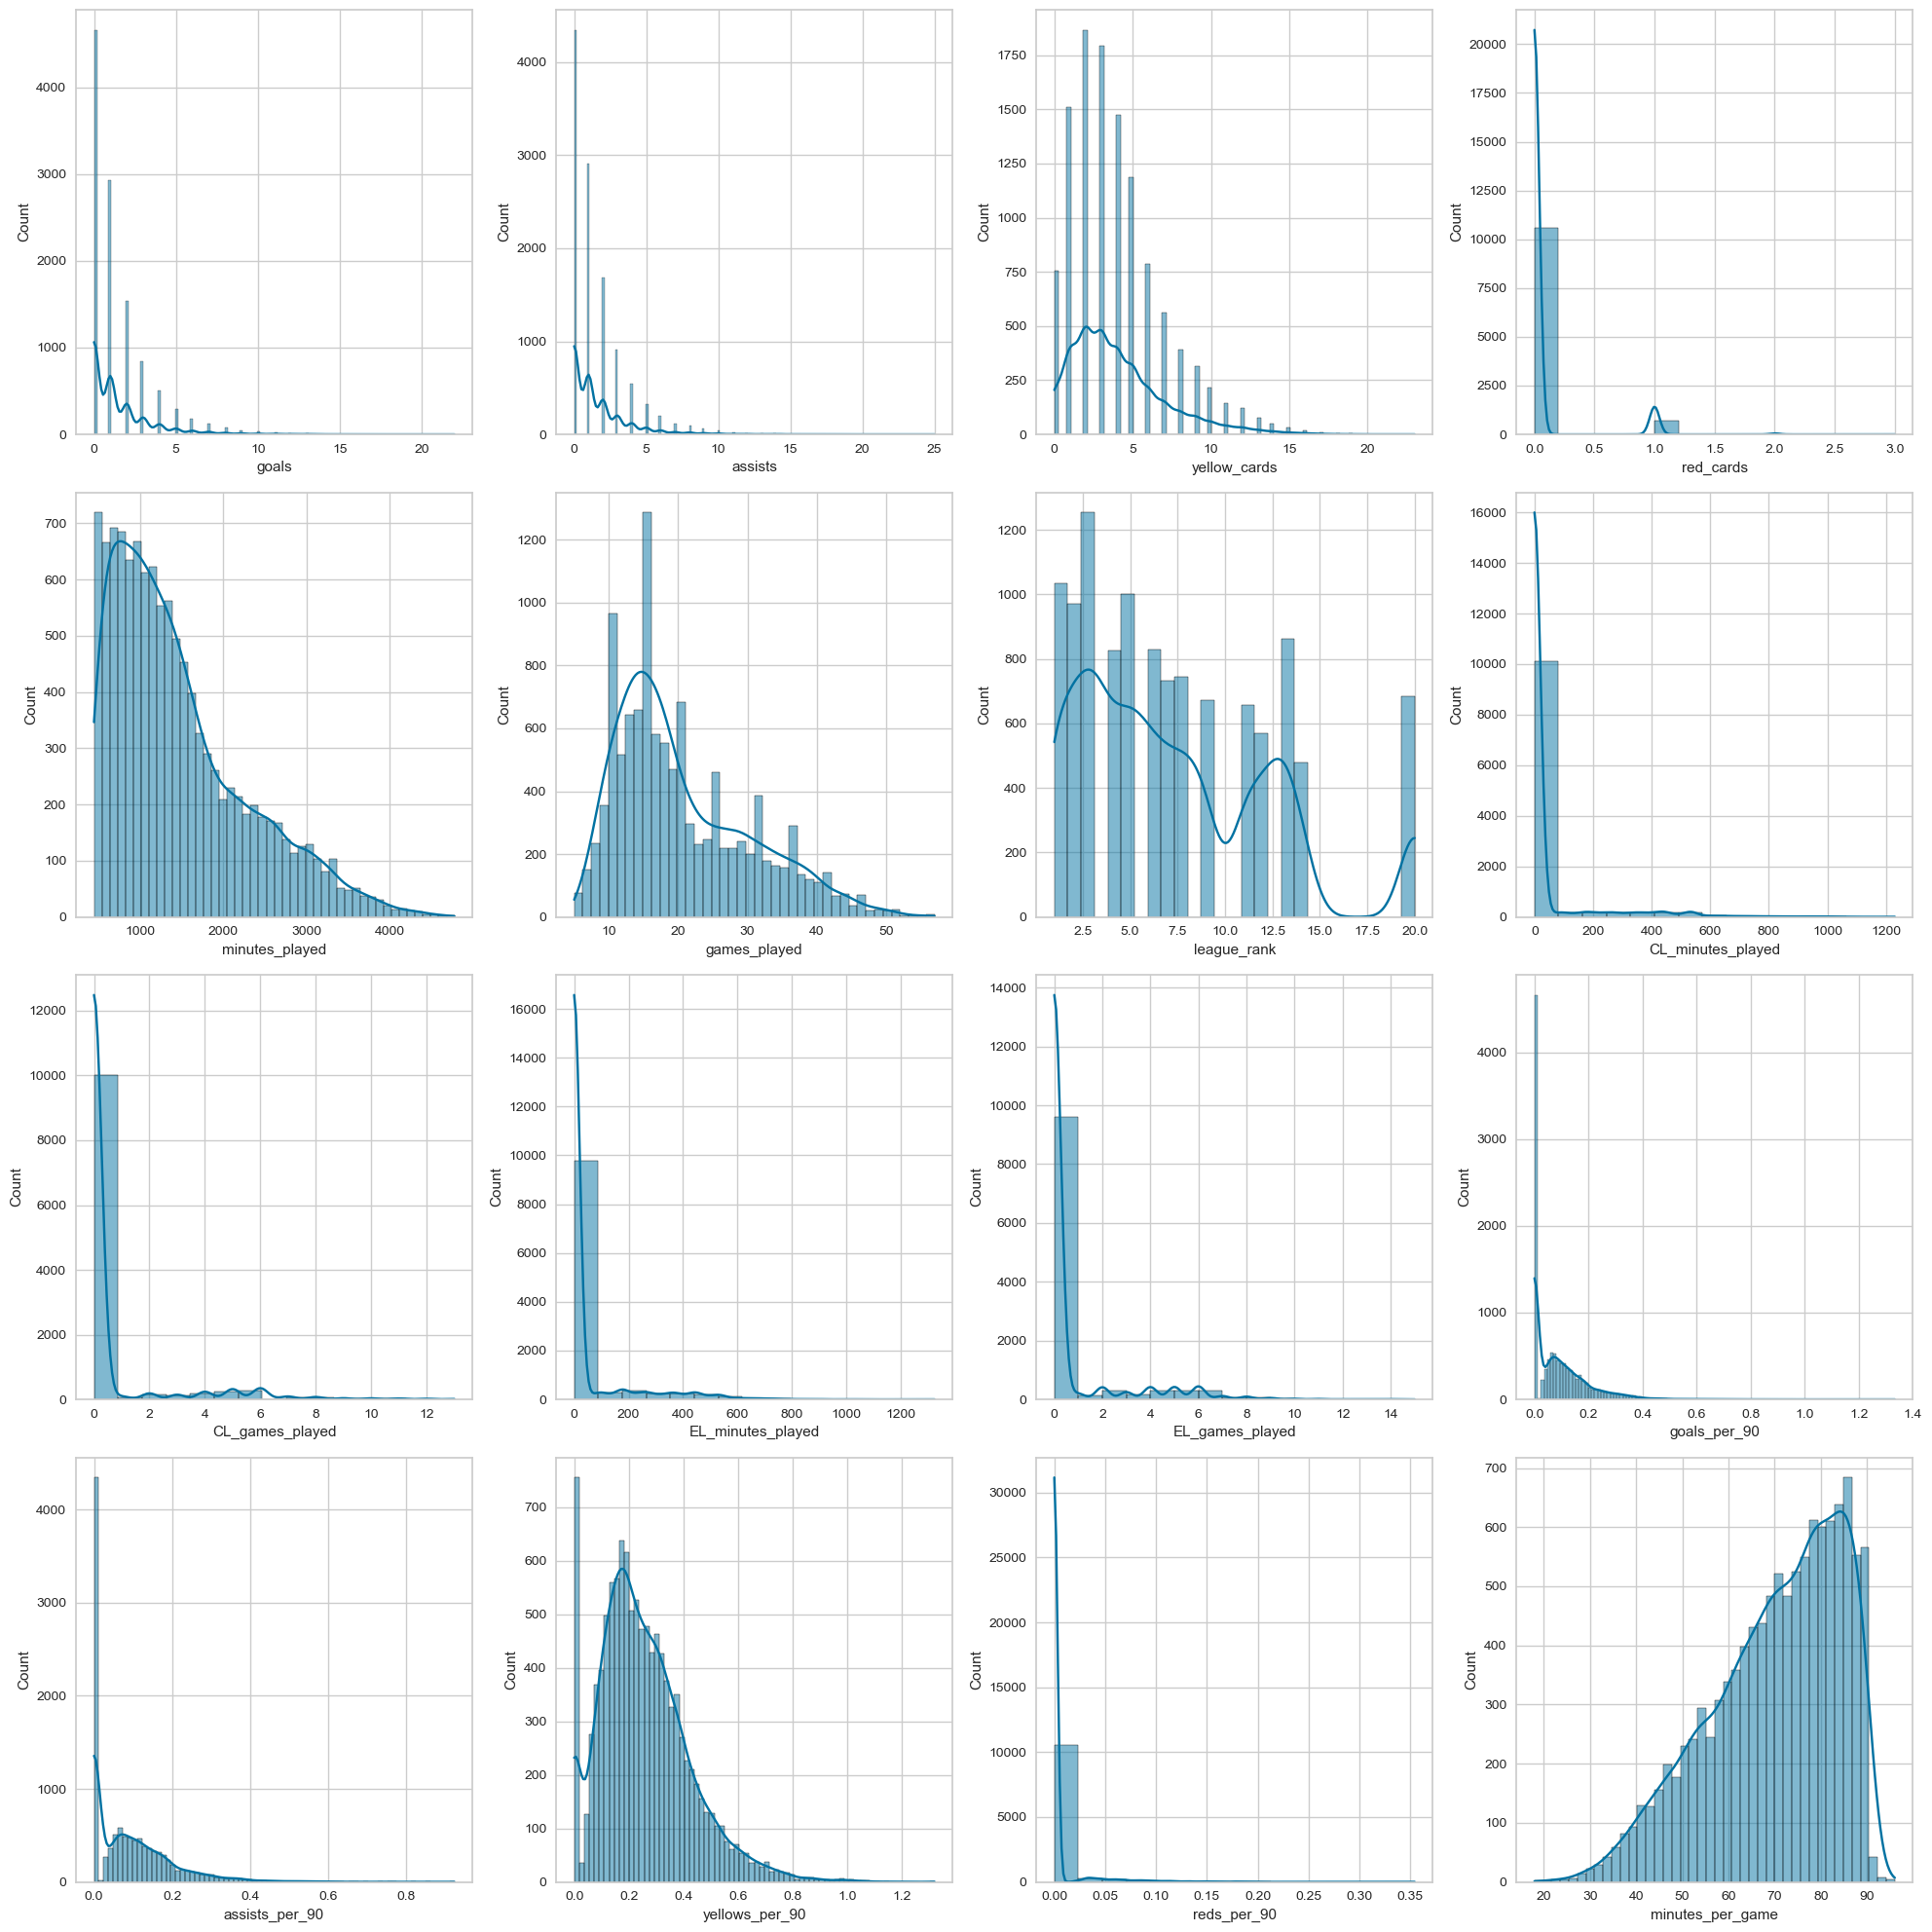

In [8]:
#plot distributions
num_cols = 4
num_rows = 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5*num_cols, 5*num_rows))
for i, column_name in enumerate(df_mid2.columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(data=df_mid2, x=column_name, kde=True, ax=axes[row][col])
plt.tight_layout()    
plt.show();

Since the distribution of the variables is mostly Gaussian-like with skews for some variables, we use PowerTransformer to scale the data.   

In [9]:
scaler = PowerTransformer(method='yeo-johnson')
df_mid_scaled = pd.DataFrame(scaler.fit_transform(df_mid2), 
                 columns=df_mid2.columns)
df_mid_scaled

goals   assists  yellow_cards  red_cards  minutes_played  \
0     -1.089648  0.731045     -0.567848   -0.26645        0.431078   
1      0.243365 -1.136827     -0.125782   -0.26645       -0.683255   
2     -1.089648 -1.136827     -1.145662   -0.26645       -1.170264   
3      0.243365  0.150293     -0.125782   -0.26645       -0.119217   
4      0.243365  0.150293      0.236721   -0.26645        0.357598   
...         ...       ...           ...        ...             ...   
11309 -1.089648 -1.136827      1.060454   -0.26645        0.450371   
11310 -1.089648 -1.136827      0.546281   -0.26645       -0.930075   
11311 -1.089648 -1.136827      0.236721   -0.26645       -1.199046   
11312 -1.089648  0.150293     -1.145662   -0.26645       -1.343958   
11313  0.243365  0.150293      0.546281   -0.26645       -0.157428   

       games_played  league_rank  CL_minutes_played  CL_games_played  \
0          0.172577    -0.522528           2.784858         2.787548   
1         -0.939658    -0.522528          -0.359504        -0.359510   
2         -0.764298    -0.522528           2.782757         2.776403   
3          0.172577    -0.522528           2.780627         2.776403   
4         -0.179158     0.187829          -0.359504        -0.359510   
...             ...          ...                ...              ...   
11309      0.563959    -0.020498          -0.359504        -0.359510   
11310     -0.451572    -0.254495          -0.359504        -0.359510   
11311     -1.339733    -0.254495          -0.359504        -0.359510   
11312     -0.764298    -0.254495          -0.359504        -0.359510   
11313     -0.764298     0.991562          -0.359504        -0.359510   

       EL_minutes_played  EL_games_played  goals_per_90  assists_per_90  \
0              -0.422041         -0.42204     -1.043495        0.596182   
1              -0.422041         -0.42204      0.589289       -1.089684   
2              -0.422041         -0.42204     -1.043495       -1.089684   
3              -0.422041         -0.42204      0.280269        0.183118   
4              -0.422041         -0.42204      0.042893       -0.050914   
...                  ...              ...           ...             ...   
11309          -0.422041         -0.42204     -1.043495       -1.089684   
11310          -0.422041         -0.42204     -1.043495       -1.089684   
11311          -0.422041         -0.42204     -1.043495       -1.089684   
11312          -0.422041         -0.42204     -1.043495        0.883567   
11313          -0.422041         -0.42204      0.300354        0.203064   

       yellows_per_90  reds_per_90  minutes_per_game  
0           -0.891586     -0.26645          0.627825  
1            0.475473     -0.26645          0.062094  
2           -0.728626     -0.26645         -1.282378  
3           -0.021195     -0.26645         -0.899507  
4            0.022856     -0.26645          1.618332  
...               ...          ...               ...  
11309        0.917272     -0.26645         -0.371812  
11310        1.744924     -0.26645         -1.331004  
11311        1.567445     -0.26645         -0.388927  
11312       -0.629210     -0.26645         -1.500104  
11313        0.905945     -0.26645          1.513932  

[11314 rows x 16 columns]

Our filtered and scaled dataset for clustering is called df_mid_scaled, it has 11312 entries across 16 features.

### 2. PCA Dimensionality Reduction

Since our dataset has 16 features, we want to reduce the dimensionality of the data using PCA, which retaining as much of the original variance as possible.

In [10]:
pca_loading_vectors = pd.DataFrame(PCA().fit(df_mid_scaled).components_.T, 
                                    index=df_mid_scaled.columns, 
                                    columns=['V1', 'V2', 'V3', 'V4','V5', 'V6', 'V7', 'V8', 'V9',
                                            'V10', 'V11', 'V12', 'V13', 'V14','V15', 'V16'])
pca_loading_vectors

V1        V2        V3        V4        V5        V6  \
goals              0.346034 -0.172648  0.134297 -0.191635 -0.125056  0.485059   
assists            0.364360 -0.163569  0.125102 -0.151308 -0.050212 -0.389126   
yellow_cards       0.247464  0.392742 -0.174307  0.229479 -0.316853  0.077726   
red_cards          0.067110  0.432631  0.472552 -0.064340  0.282111  0.022920   
minutes_played     0.404558  0.156704 -0.046562  0.024819 -0.225874 -0.139169   
games_played       0.405801  0.114391 -0.077244  0.070044 -0.072129 -0.074790   
league_rank       -0.100581  0.036082  0.017796 -0.188096 -0.134717  0.061680   
CL_minutes_played  0.228227 -0.192665  0.048947  0.527109  0.254275  0.044367   
CL_games_played    0.228317 -0.192679  0.049020  0.527143  0.254122  0.044381   
EL_minutes_played  0.202305  0.146220 -0.441312 -0.249312  0.391395  0.034347   
EL_games_played    0.202570  0.146402 -0.441257 -0.249698  0.391038  0.034348   
goals_per_90       0.249969 -0.241032  0.167164 -0.226581 -0.074291  0.581815   
assists_per_90     0.264505 -0.237081  0.160973 -0.185201  0.011273 -0.398343   
yellows_per_90    -0.026321  0.355109 -0.173694  0.257031 -0.221736  0.209273   
reds_per_90        0.067013  0.432610  0.472594 -0.064403  0.282111  0.022928   
minutes_per_game   0.139620  0.135876  0.050403 -0.081238 -0.397181 -0.173669   

                         V7        V8        V9       V10       V11       V12  \
goals             -0.013055 -0.037581  0.029610 -0.485093  0.186709  0.521144   
assists            0.312556  0.014356  0.023118 -0.484598  0.163394 -0.536524   
yellow_cards       0.228199 -0.013086 -0.010474 -0.199849 -0.705514  0.015739   
red_cards          0.000283  0.016223  0.022241  0.000847  0.001379  0.000056   
minutes_played    -0.330340 -0.024904 -0.189969  0.149670  0.116305  0.011573   
games_played      -0.193870 -0.132938 -0.541689  0.230924  0.212327 -0.005027   
league_rank        0.066996  0.902494 -0.334538 -0.004464 -0.002456 -0.002215   
CL_minutes_played -0.043409  0.222057  0.112937  0.006614  0.000116  0.001059   
CL_games_played   -0.043474  0.221917  0.112473  0.006898  0.001610 -0.000796   
EL_minutes_played -0.003426  0.082077  0.140821  0.006269  0.001833  0.001085   
EL_games_played   -0.003578  0.081401  0.139652  0.005216  0.002189 -0.000247   
goals_per_90       0.084573 -0.037068  0.087855  0.437939 -0.174106 -0.466021   
assists_per_90     0.465803  0.026908  0.087790  0.428549 -0.151281  0.471950   
yellows_per_90     0.561154  0.005476  0.141410  0.163865  0.564687 -0.014439   
reds_per_90        0.000363  0.016204  0.022219  0.001362  0.001922  0.000047   
minutes_per_game  -0.395028  0.225495  0.675203  0.108189  0.099949 -0.004040   

                        V13       V14       V15       V16  
goals              0.023367 -0.000098  0.000455 -0.000132  
assists            0.013336 -0.000965 -0.000852 -0.000116  
yellow_cards       0.068849 -0.000198  0.000506 -0.000415  
red_cards          0.000525  0.000090  0.000912  0.707112  
minutes_played    -0.746125  0.001157  0.002558  0.000552  
games_played       0.594510 -0.001618 -0.002766 -0.000268  
league_rank       -0.000969  0.000087 -0.000017  0.000010  
CL_minutes_played -0.005479  0.012758 -0.706924  0.000860  
CL_games_played   -0.000172 -0.011974  0.707060 -0.000934  
EL_minutes_played -0.001899 -0.706847 -0.012244  0.000096  
EL_games_played    0.000863  0.707146  0.012475 -0.000132  
goals_per_90      -0.024182 -0.000054 -0.000432  0.000121  
assists_per_90    -0.011466  0.000873  0.000787  0.000122  
yellows_per_90    -0.056173  0.000243 -0.000378  0.000325  
reds_per_90       -0.000431 -0.000104 -0.000883 -0.707099  
minutes_per_game   0.283696 -0.000029 -0.001021 -0.000156

In [11]:
#PCA model 
pca = PCA()
df_pca = pd.DataFrame(pca.fit_transform(df_mid_scaled), columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9','PC10', 'PC11', 'PC12', 'PC13', 'PC14','PC15', 'PC16'], index=df_mid_scaled.index)
df_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0      1.119158 -1.634848  0.503043  3.117083  1.208583 -1.896442 -0.895896   
1     -1.481812 -0.060799 -0.063447  0.163370 -0.490481  1.476306 -0.195767   
2     -1.452362 -1.713805  0.120402  3.664053  2.614922  0.115222 -0.839624   
3      1.237570 -1.799235  0.483852  3.153542  1.361990  0.468523  0.199827   
4      0.102491  0.082924  0.172752 -0.314049 -1.521067 -0.250968 -0.585523   
...         ...       ...       ...       ...       ...       ...       ...   
11309 -1.111592  1.494470 -0.980782  1.248827 -0.936107 -0.099503 -0.258788   
11310 -2.341577  1.115174 -0.944706  1.360111 -0.159157  0.453953  1.104446   
11311 -2.751208  0.914832 -0.731308  1.098037 -0.271079  0.332998  0.823105   
11312 -2.024826 -1.194358  0.276150 -0.217020  1.044192 -1.350926  0.971683   
11313 -0.253837  0.262997  0.127549 -0.317870 -1.739503  0.189668  0.499407   

            PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0      0.904400  0.746326  0.147047  0.057696 -0.185399 -0.042076  0.002058   
1     -0.625273  0.649864  0.006495  0.004482 -0.063732 -0.074875  0.000510   
2      0.571419  0.104674 -0.190856 -0.068897  0.003569 -0.000674  0.002367   
3      0.450651  0.042408 -0.008875  0.006642  0.003229 -0.087086  0.001667   
4      0.299184  0.858461 -0.061381  0.077768  0.003179  0.110304  0.000014   
...         ...       ...       ...       ...       ...       ...       ...   
11309 -0.400642 -0.973773  0.241104 -0.141051  0.020979 -0.085181 -0.000464   
11310 -0.647474 -0.608374 -0.064367  0.217597 -0.005540 -0.012723 -0.000108   
11311 -0.307193  0.538068 -0.175016  0.210072 -0.010303 -0.084138  0.001009   
11312 -0.553010 -0.589544 -0.045829 -0.148999  0.240283  0.073606  0.000163   
11313  1.089696  1.100444  0.015966  0.078241 -0.009195  0.078878  0.000799   

           PC15      PC16  
0      0.002019 -0.000159  
1      0.000363  0.000143  
2     -0.004019 -0.000181  
3     -0.002619 -0.000116  
4     -0.000368 -0.000108  
...         ...       ...  
11309  0.000069  0.000068  
11310 -0.000243  0.000209  
11311  0.000474  0.000222  
11312  0.000233  0.000112  
11313 -0.000063  0.000010  

[11314 rows x 16 columns]

In [12]:
print("Ratio of Variance Explained:\n__________________________\n")
print(pca.explained_variance_ratio_)

Ratio of Variance Explained:
__________________________

[2.53925984e-01 1.33644396e-01 1.20561920e-01 1.19069409e-01
 1.11180957e-01 8.02940907e-02 7.49434834e-02 5.90803093e-02
 4.22277525e-02 1.79426821e-03 1.53381082e-03 1.19503850e-03
 5.33295512e-04 1.21355531e-05 3.07921770e-06 7.02267801e-08]


The first principal component 25.4% of the variance in the data, the second - 13.3%, the third - 12%, and so on.

Now let's visualize the amount of variance explained by each principal component and cumulatively. This will allow to pick the number of principal components to use moving forward. 

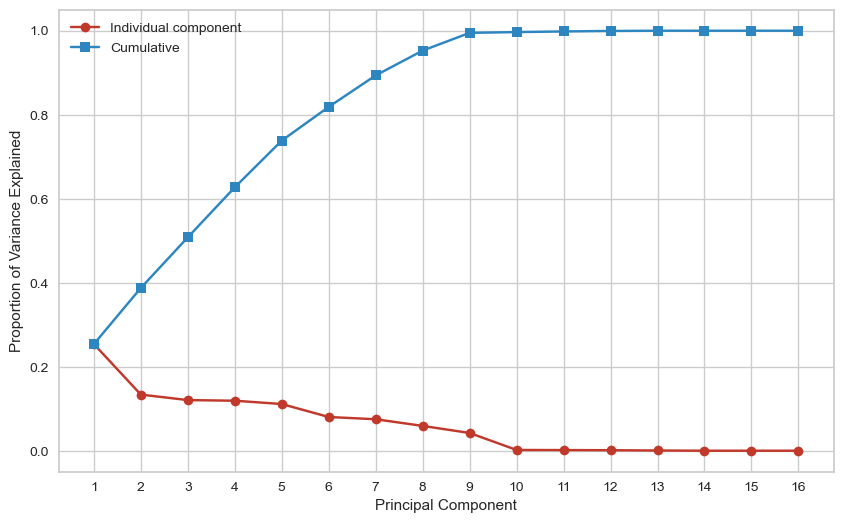

In [13]:
plt.figure(figsize=(10,6))

feats = range(1,17,1)

plt.plot(feats, pca.explained_variance_ratio_, '-o', label='Individual component', color = colors[0])
plt.plot(feats, np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative', color = colors[1])

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xticks(feats)
plt.legend(loc=2)
plt.show();

We can see from the scree plot that 7 principal components explain around 90% of the variance. From now on, we decide to work only with 7 principal compnents.

In [14]:
pca = PCA(n_components=7)

#We fit and transform X to get the principal components from PCA
df_pca = pd.DataFrame(pca.fit_transform(df_mid_scaled), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], index=df_mid_scaled.index)
df_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0      1.119158 -1.634848  0.503043  3.117083  1.208583 -1.896442 -0.895896
1     -1.481812 -0.060799 -0.063447  0.163370 -0.490481  1.476306 -0.195767
2     -1.452362 -1.713805  0.120402  3.664053  2.614922  0.115222 -0.839624
3      1.237570 -1.799235  0.483852  3.153542  1.361990  0.468523  0.199827
4      0.102491  0.082924  0.172752 -0.314049 -1.521067 -0.250968 -0.585523
...         ...       ...       ...       ...       ...       ...       ...
11309 -1.111592  1.494470 -0.980782  1.248827 -0.936107 -0.099503 -0.258788
11310 -2.341577  1.115174 -0.944706  1.360111 -0.159157  0.453953  1.104446
11311 -2.751208  0.914832 -0.731308  1.098037 -0.271079  0.332998  0.823105
11312 -2.024826 -1.194358  0.276150 -0.217020  1.044192 -1.350926  0.971683
11313 -0.253837  0.262997  0.127549 -0.317870 -1.739503  0.189668  0.499407

[11314 rows x 7 columns]

### 3. KMeans clustering

The most popular and relatively simple clustering method is KMeans clustering. The main feature of KMeans clustering is that clusters are separated by their distance to each other, where the distance is measured using a chosen metric, typically the Euclidean distance. Now we will try to find the optimal number of clusters using the elbow method.

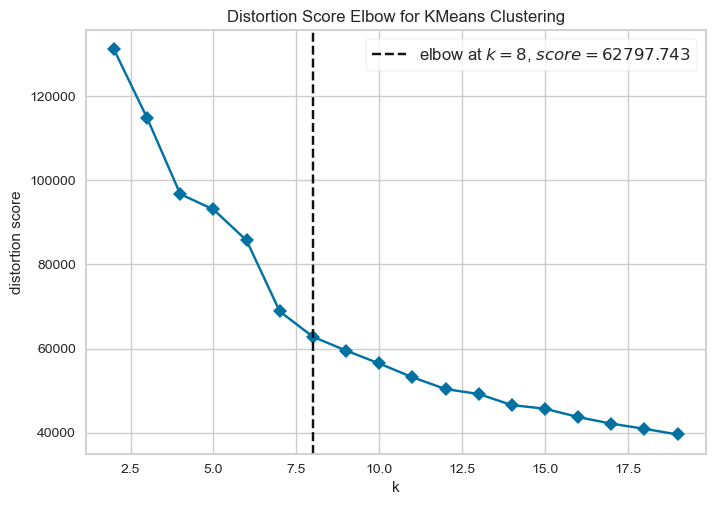

In [15]:
#check number of clusters
kmeans = KMeans(n_init='auto', random_state = seed)
visualizer = KElbowVisualizer(kmeans, k=(2,20), timings = False, locate_elbow=True)
visualizer.fit(df_pca)
visualizer.show(); 

The recommended k using the Euclidean distance metric is 8. This might be too many clusters and more than what we expect basede on the domain knowledge. Let's check the k with the Calinski-Harabasz metric.

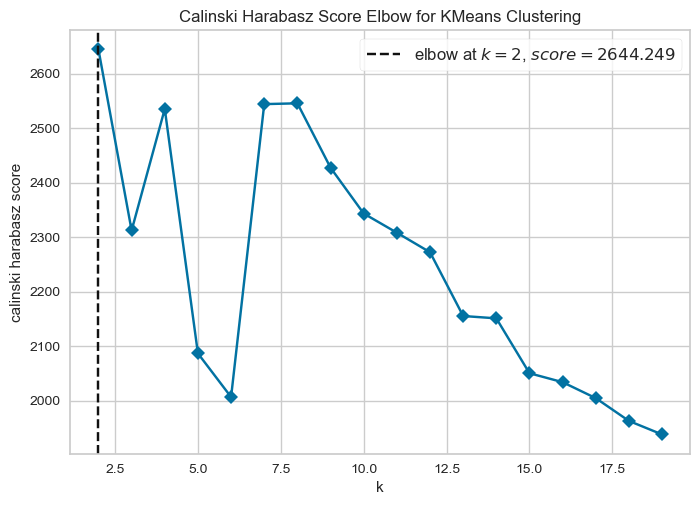

In [16]:
#check number of clusters with Calinski-Harabasz
visualizer = KElbowVisualizer(kmeans, k=(2,20), metric='calinski_harabasz', timings=False, locate_elbow=True, n_init = 'auto')
visualizer.fit(df_pca)
visualizer.show();

The recommended k with the Calinski-Harabasz metric is 2. This is a very low number of clusters. Since we are getting different number of k's with different metrics (8 is too many, 2 is too few), let's compare silhouette scores for k's and visualize.

In [17]:
n_clusters = range(2,8)
for i in n_clusters:
    kmeans = KMeans(n_clusters=i, random_state=seed, n_init = 'auto')
    kmeans.fit(df_pca)
    print("k = ",i,"- silhouette score = ", silhouette_score(df_pca, kmeans.labels_),"\n")

k =  2 - silhouette score =  0.20647752667460875 

k =  3 - silhouette score =  0.30594603023077005 

k =  4 - silhouette score =  0.2256807417373957 

k =  5 - silhouette score =  0.22362884396251562 

k =  6 - silhouette score =  0.19471290359103252 

k =  7 - silhouette score =  0.23285403224913262 



In terms of silhouette scores, k = 3 has the highest silhouette score, which might be a good number of clusters for our dataset.

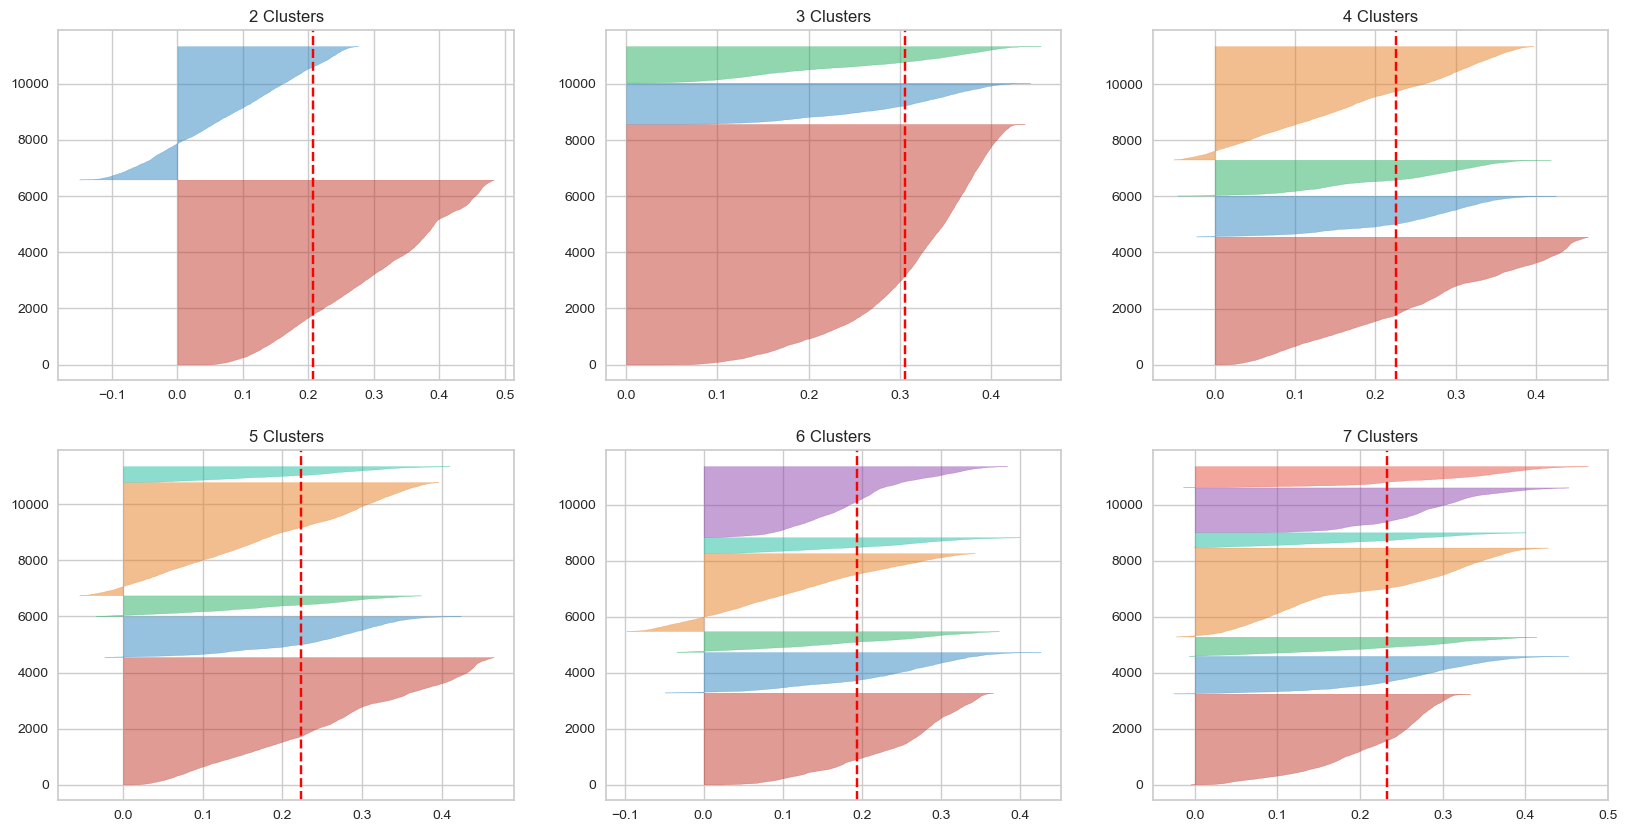

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for i in range(2, 8):
    row = (i-2) // 3
    col = (i-2) % 3
    kmeans = KMeans(n_clusters=i, random_state=seed, n_init='auto')
    viz = SilhouetteVisualizer(kmeans, colors=colors[:i], ax=ax[row][col])
    viz.fit(df_pca)
    ax[row][col].set_title(f'{i} Clusters')

Having looked at the quality of clustering for numbers of clusters in 2-7 using silhouette score and visualizer, we observe that 3 clusters have the best silhouette score but results in one of the clusters being too thick and contain too many data points. Given that we are clustering real-world data, that is acceptable. We also want to see how clustering into 7 groups may work out. k = 7 has the second highest silhouette score and clusters are relatively comparable in size. Looking at 5 clusters might also give interesting results.

In [19]:
#kmeans with 3 clusters
kmeans3 = KMeans(n_clusters = 3, random_state = seed, n_init = 'auto')
kmeans3.fit(df_pca)

KMeans(n_clusters=3, n_init='auto', random_state=1)

In [20]:
df_mid_labeled = pd.concat([df_mid_scaled.reset_index(drop = True), df_pca], axis = 1)
df_mid_labeled['kmeans3_labels'] = kmeans3.labels_
df_mid_labeled.head()

goals   assists  yellow_cards  red_cards  minutes_played  games_played  \
0 -1.089648  0.731045     -0.567848   -0.26645        0.431078      0.172577   
1  0.243365 -1.136827     -0.125782   -0.26645       -0.683255     -0.939658   
2 -1.089648 -1.136827     -1.145662   -0.26645       -1.170264     -0.764298   
3  0.243365  0.150293     -0.125782   -0.26645       -0.119217      0.172577   
4  0.243365  0.150293      0.236721   -0.26645        0.357598     -0.179158   

   league_rank  CL_minutes_played  CL_games_played  EL_minutes_played  ...  \
0    -0.522528           2.784858         2.787548          -0.422041  ...   
1    -0.522528          -0.359504        -0.359510          -0.422041  ...   
2    -0.522528           2.782757         2.776403          -0.422041  ...   
3    -0.522528           2.780627         2.776403          -0.422041  ...   
4     0.187829          -0.359504        -0.359510          -0.422041  ...   

   reds_per_90  minutes_per_game       PC1       PC2       PC3       PC4  \
0     -0.26645          0.627825  1.119158 -1.634848  0.503043  3.117083   
1     -0.26645          0.062094 -1.481812 -0.060799 -0.063447  0.163370   
2     -0.26645         -1.282378 -1.452362 -1.713805  0.120402  3.664053   
3     -0.26645         -0.899507  1.237570 -1.799235  0.483852  3.153542   
4     -0.26645          1.618332  0.102491  0.082924  0.172752 -0.314049   

        PC5       PC6       PC7  kmeans3_labels  
0  1.208583 -1.896442 -0.895896               2  
1 -0.490481  1.476306 -0.195767               0  
2  2.614922  0.115222 -0.839624               2  
3  1.361990  0.468523  0.199827               2  
4 -1.521067 -0.250968 -0.585523               0  

[5 rows x 24 columns]

We want to keep PCA values and the cluster labels for every model with the original dataset to make comparisons in the future. So, in the code above me merged the original dataset with the PCA dataset and created a column with cluster labels for KMeans model with k = 3. We also create columns for KMeans with k = 5 and k = 7.

In [21]:
kmeans5 = KMeans(n_clusters = 5, random_state = seed, n_init = 'auto')
kmeans5.fit(df_pca)

KMeans(n_clusters=5, n_init='auto', random_state=1)

In [22]:
df_mid_labeled['kmeans5_labels'] = kmeans5.labels_
df_mid_labeled.head()

goals   assists  yellow_cards  red_cards  minutes_played  games_played  \
0 -1.089648  0.731045     -0.567848   -0.26645        0.431078      0.172577   
1  0.243365 -1.136827     -0.125782   -0.26645       -0.683255     -0.939658   
2 -1.089648 -1.136827     -1.145662   -0.26645       -1.170264     -0.764298   
3  0.243365  0.150293     -0.125782   -0.26645       -0.119217      0.172577   
4  0.243365  0.150293      0.236721   -0.26645        0.357598     -0.179158   

   league_rank  CL_minutes_played  CL_games_played  EL_minutes_played  ...  \
0    -0.522528           2.784858         2.787548          -0.422041  ...   
1    -0.522528          -0.359504        -0.359510          -0.422041  ...   
2    -0.522528           2.782757         2.776403          -0.422041  ...   
3    -0.522528           2.780627         2.776403          -0.422041  ...   
4     0.187829          -0.359504        -0.359510          -0.422041  ...   

   minutes_per_game       PC1       PC2       PC3       PC4       PC5  \
0          0.627825  1.119158 -1.634848  0.503043  3.117083  1.208583   
1          0.062094 -1.481812 -0.060799 -0.063447  0.163370 -0.490481   
2         -1.282378 -1.452362 -1.713805  0.120402  3.664053  2.614922   
3         -0.899507  1.237570 -1.799235  0.483852  3.153542  1.361990   
4          1.618332  0.102491  0.082924  0.172752 -0.314049 -1.521067   

        PC6       PC7  kmeans3_labels  kmeans5_labels  
0 -1.896442 -0.895896               2               4  
1  1.476306 -0.195767               0               0  
2  0.115222 -0.839624               2               4  
3  0.468523  0.199827               2               4  
4 -0.250968 -0.585523               0               3  

[5 rows x 25 columns]

In [23]:
kmeans7 = KMeans(n_clusters = 7, random_state = seed, n_init = 'auto')
kmeans7.fit(df_pca)

KMeans(n_clusters=7, n_init='auto', random_state=1)

In [24]:
df_mid_labeled['kmeans7_labels'] = kmeans7.labels_
df_mid_labeled.head()

goals   assists  yellow_cards  red_cards  minutes_played  games_played  \
0 -1.089648  0.731045     -0.567848   -0.26645        0.431078      0.172577   
1  0.243365 -1.136827     -0.125782   -0.26645       -0.683255     -0.939658   
2 -1.089648 -1.136827     -1.145662   -0.26645       -1.170264     -0.764298   
3  0.243365  0.150293     -0.125782   -0.26645       -0.119217      0.172577   
4  0.243365  0.150293      0.236721   -0.26645        0.357598     -0.179158   

   league_rank  CL_minutes_played  CL_games_played  EL_minutes_played  ...  \
0    -0.522528           2.784858         2.787548          -0.422041  ...   
1    -0.522528          -0.359504        -0.359510          -0.422041  ...   
2    -0.522528           2.782757         2.776403          -0.422041  ...   
3    -0.522528           2.780627         2.776403          -0.422041  ...   
4     0.187829          -0.359504        -0.359510          -0.422041  ...   

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.119158 -1.634848  0.503043  3.117083  1.208583 -1.896442 -0.895896   
1 -1.481812 -0.060799 -0.063447  0.163370 -0.490481  1.476306 -0.195767   
2 -1.452362 -1.713805  0.120402  3.664053  2.614922  0.115222 -0.839624   
3  1.237570 -1.799235  0.483852  3.153542  1.361990  0.468523  0.199827   
4  0.102491  0.082924  0.172752 -0.314049 -1.521067 -0.250968 -0.585523   

   kmeans3_labels  kmeans5_labels  kmeans7_labels  
0               2               4               4  
1               0               0               0  
2               2               4               4  
3               2               4               4  
4               0               3               3  

[5 rows x 26 columns]

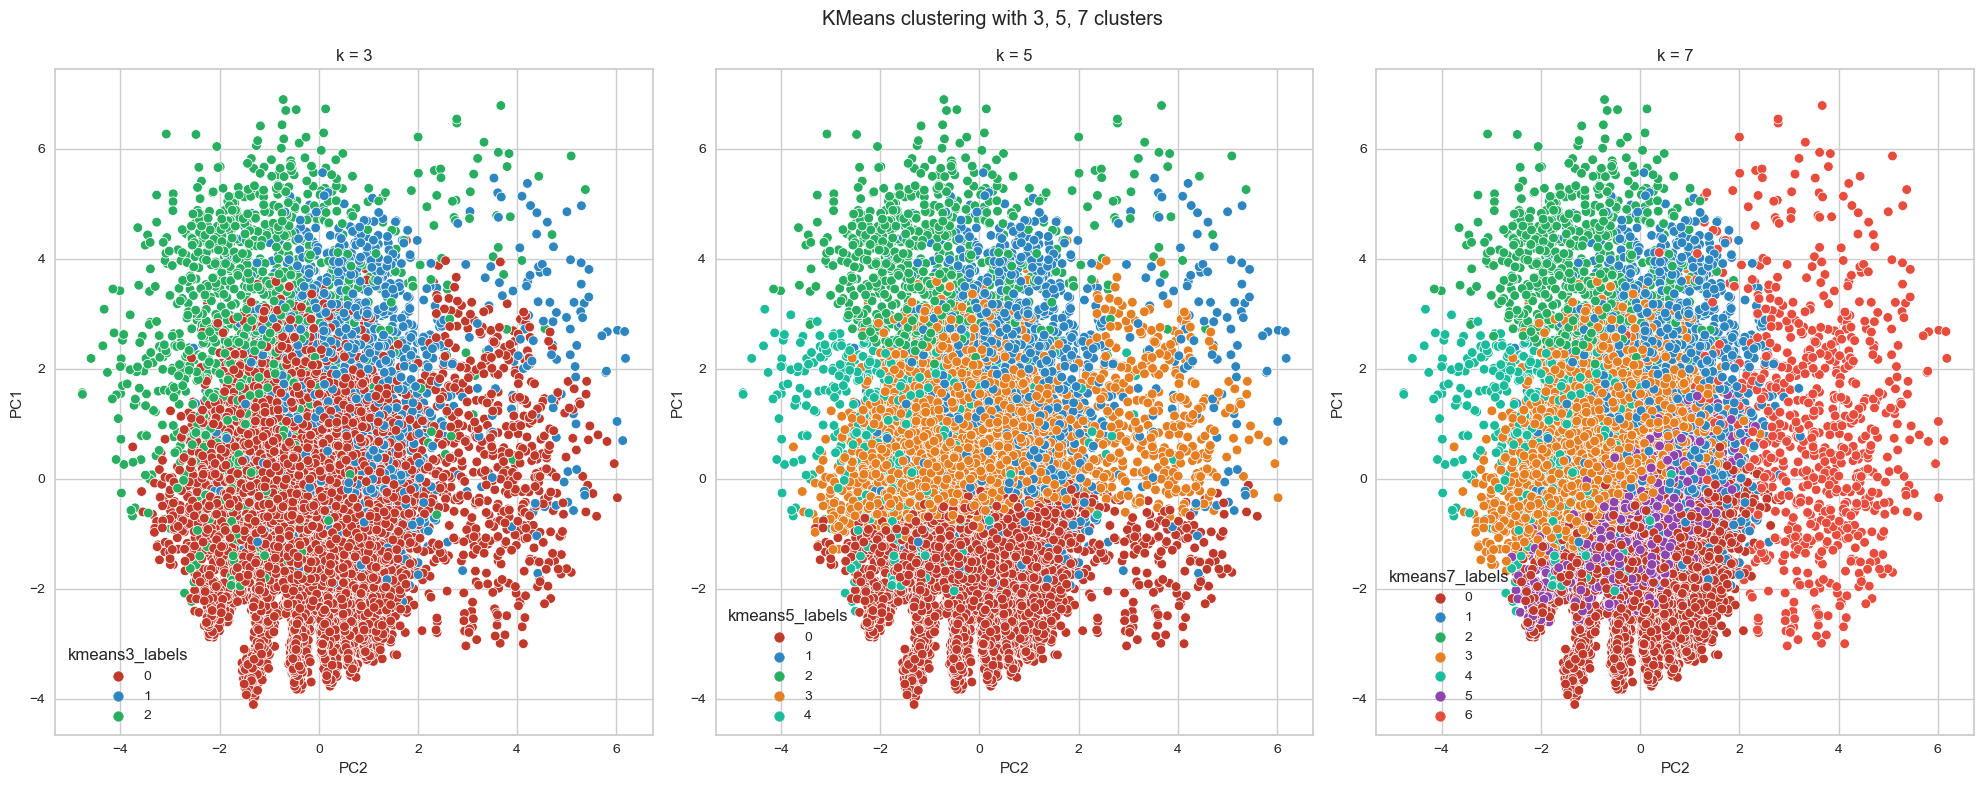

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
fig.suptitle('KMeans clustering with 3, 5, 7 clusters')
sns.scatterplot(data=df_mid_labeled, x=df_mid_labeled['PC2'], y=df_mid_labeled['PC1'], hue=df_mid_labeled['kmeans3_labels'], palette=colors[:3], ax=axes[0])
axes[0].set_title('k = 3')
sns.scatterplot(data=df_mid_labeled, x=df_mid_labeled['PC2'], y=df_mid_labeled['PC1'], hue=df_mid_labeled['kmeans5_labels'], palette=colors[:5], ax=axes[1])
axes[1].set_title('k = 5')
sns.scatterplot(data=df_mid_labeled, x=df_mid_labeled['PC2'], y=df_mid_labeled['PC1'], hue=df_mid_labeled['kmeans7_labels'], palette=colors[:7], ax=axes[2])
axes[2].set_title('k = 7')

plt.tight_layout()
plt.show()

From the scatterplots above, we see that with 3 clusters, cluster label 0 is spread out and has the most data points. As the number of clusters increase, the number of data points labeled 0 shrinks. Since data points are overlapped for many of the clusters, a 3D scatterplot might help. 

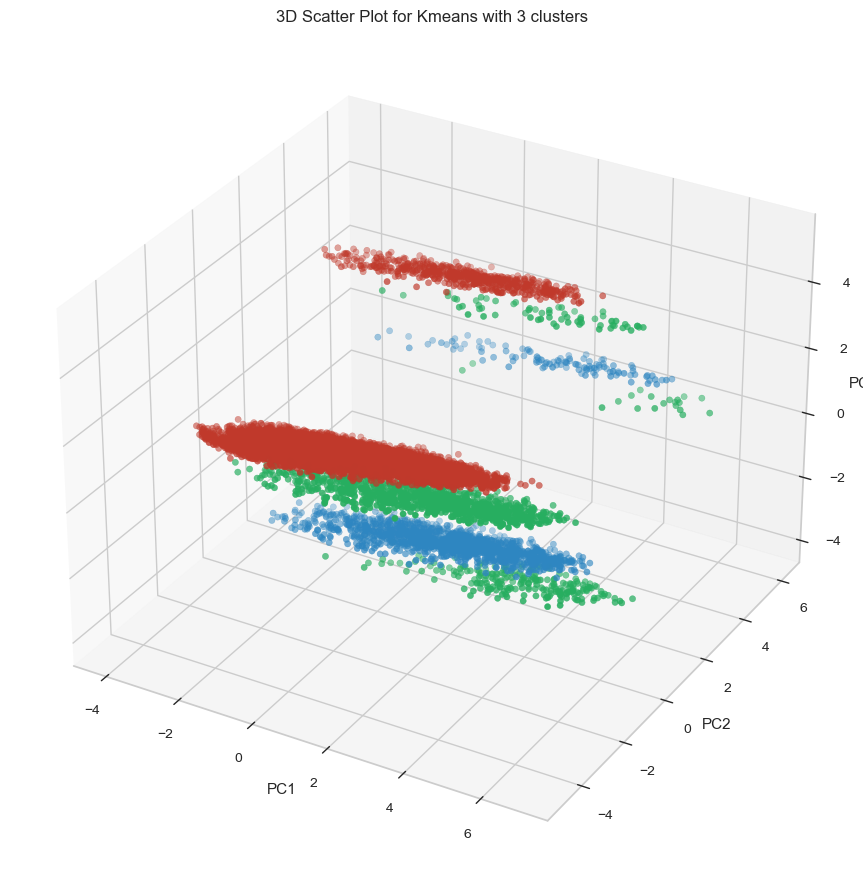

In [26]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

x = df_mid_labeled['PC1']
y = df_mid_labeled['PC2']
z = df_mid_labeled['PC3']
c = df_mid_labeled['kmeans3_labels']

ax.scatter(x, y, z, c=[colors[i] for i in c])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot for Kmeans with 3 clusters')

plt.tight_layout()
plt.show();

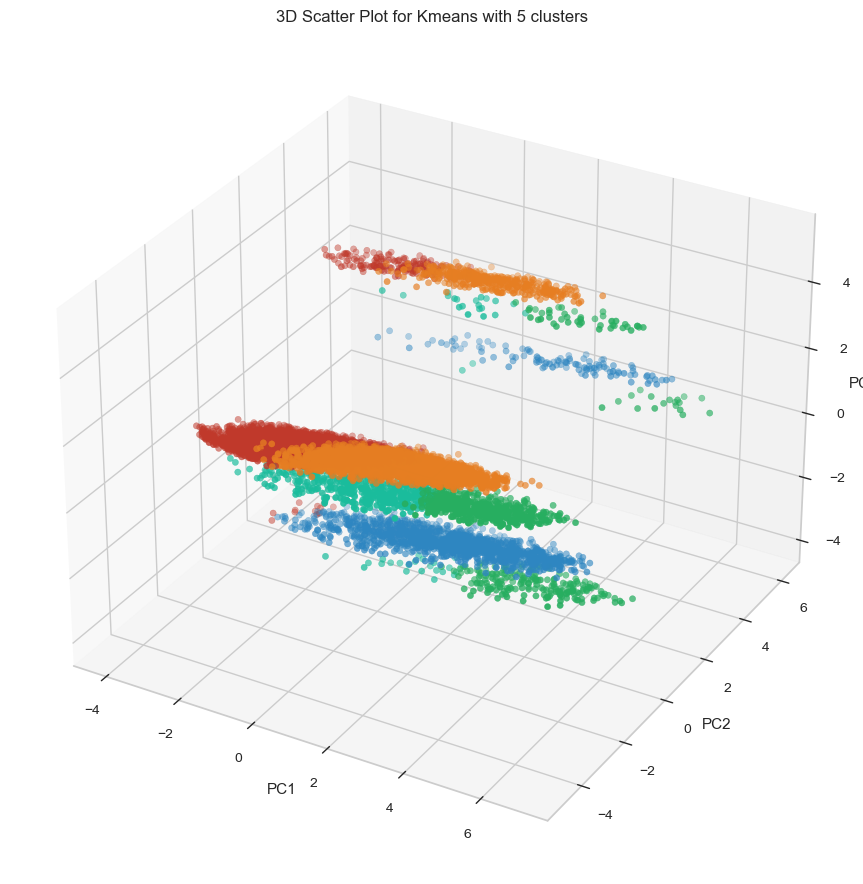

In [27]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

x = df_mid_labeled['PC1']
y = df_mid_labeled['PC2']
z = df_mid_labeled['PC3']
c = df_mid_labeled['kmeans5_labels']

ax.scatter(x, y, z, c=[colors[i] for i in c])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot for Kmeans with 5 clusters')

plt.tight_layout()
plt.show();

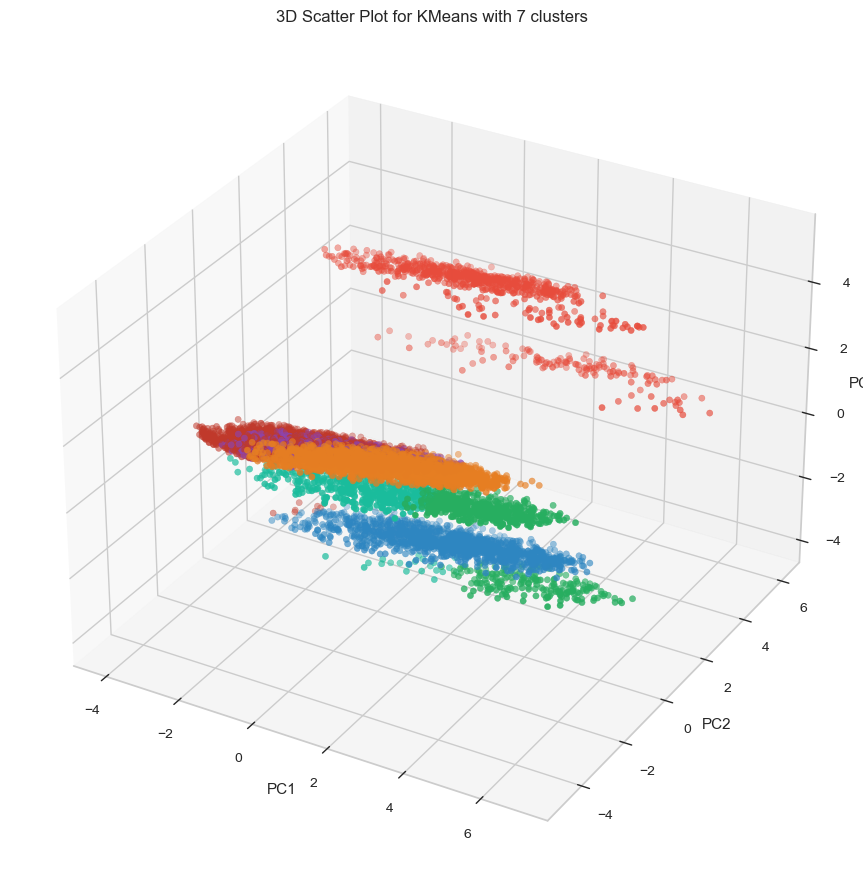

In [28]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

x = df_mid_labeled['PC1']
y = df_mid_labeled['PC2']
z = df_mid_labeled['PC3']
c = df_mid_labeled['kmeans7_labels']


ax.scatter(x, y, z, c=[colors[i] for i in c])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot for KMeans with 7 clusters')

plt.tight_layout()
plt.show();

Looking at 3D scatterplots, we can see that clusters may be separated on a 3-dimensional space, although there is still some ovelap between clusters.

#### KMeans Clustering: Validation

Now that we have 3 models of clustering using KMeans (k = 3, 5, 7), we can validate if the clusters are well-separated and meaningful. 

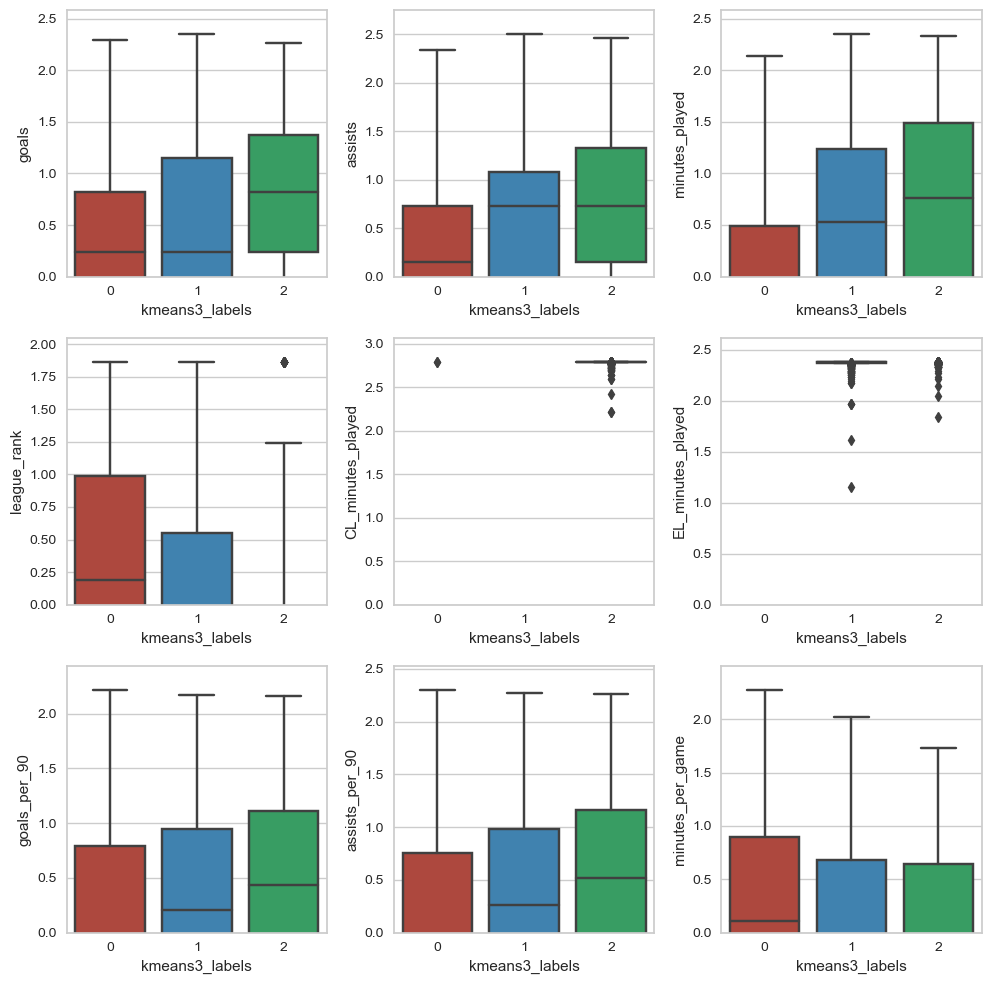

In [29]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharey=False)

vars = ['goals', 'assists', 'minutes_played', 'league_rank', 'CL_minutes_played', 'EL_minutes_played', 'goals_per_90', 'assists_per_90', 'minutes_per_game']

for i in range(3):
    for j in range(3):
        var_index = i*3 + j
        if var_index < len(vars):
            sns.boxplot(data=df_mid_labeled, x="kmeans3_labels", y=vars[var_index], ax=ax[i, j], palette=colors)
            ax[i, j].set_ylim(0, np.max(df_mid_labeled[vars[var_index]]) * 1.1)
        else:
            ax[i, j].set_axis_off()

plt.tight_layout()
plt.show();

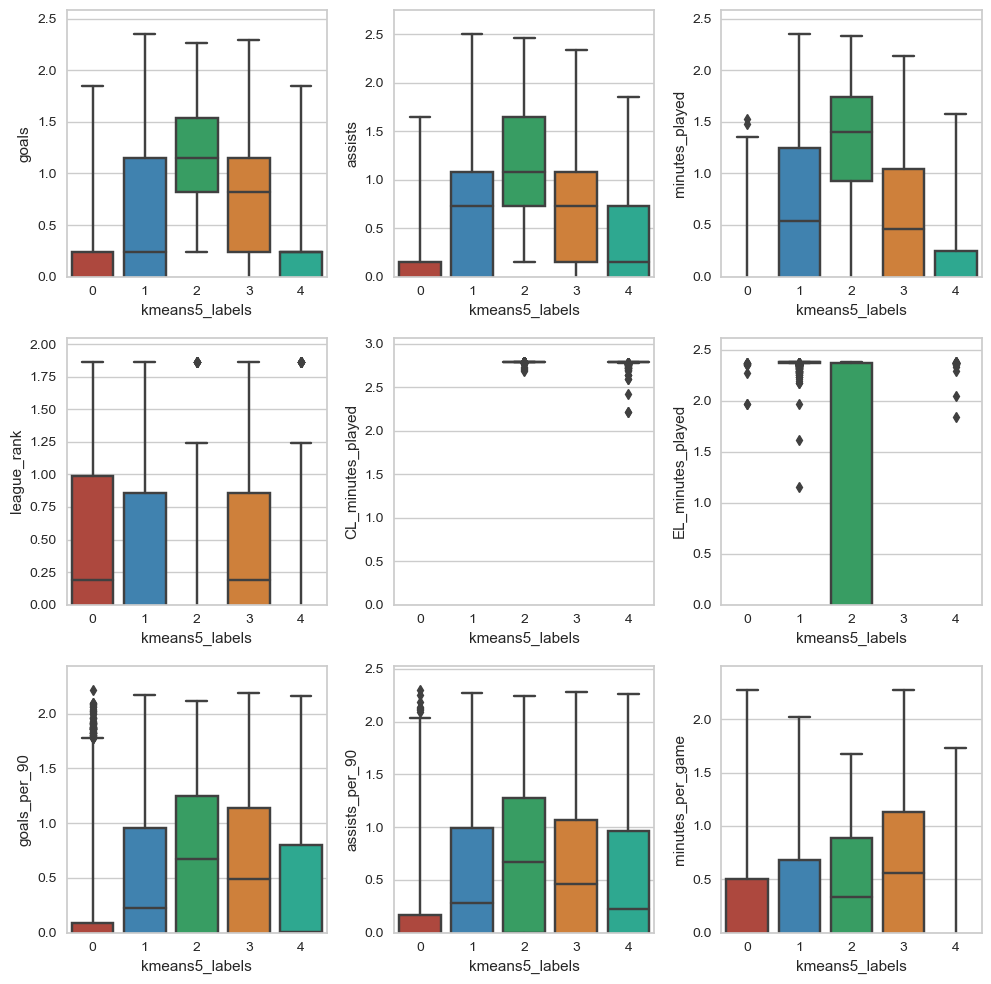

In [30]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharey=False)

for i in range(3):
    for j in range(3):
        var_index = i*3 + j
        if var_index < len(vars):
            sns.boxplot(data=df_mid_labeled, x="kmeans5_labels", y=vars[var_index], ax=ax[i, j], palette=colors)
            ax[i, j].set_ylim(0, np.max(df_mid_labeled[vars[var_index]]) * 1.1)
        else:
            ax[i, j].set_axis_off()

plt.tight_layout()
plt.show();

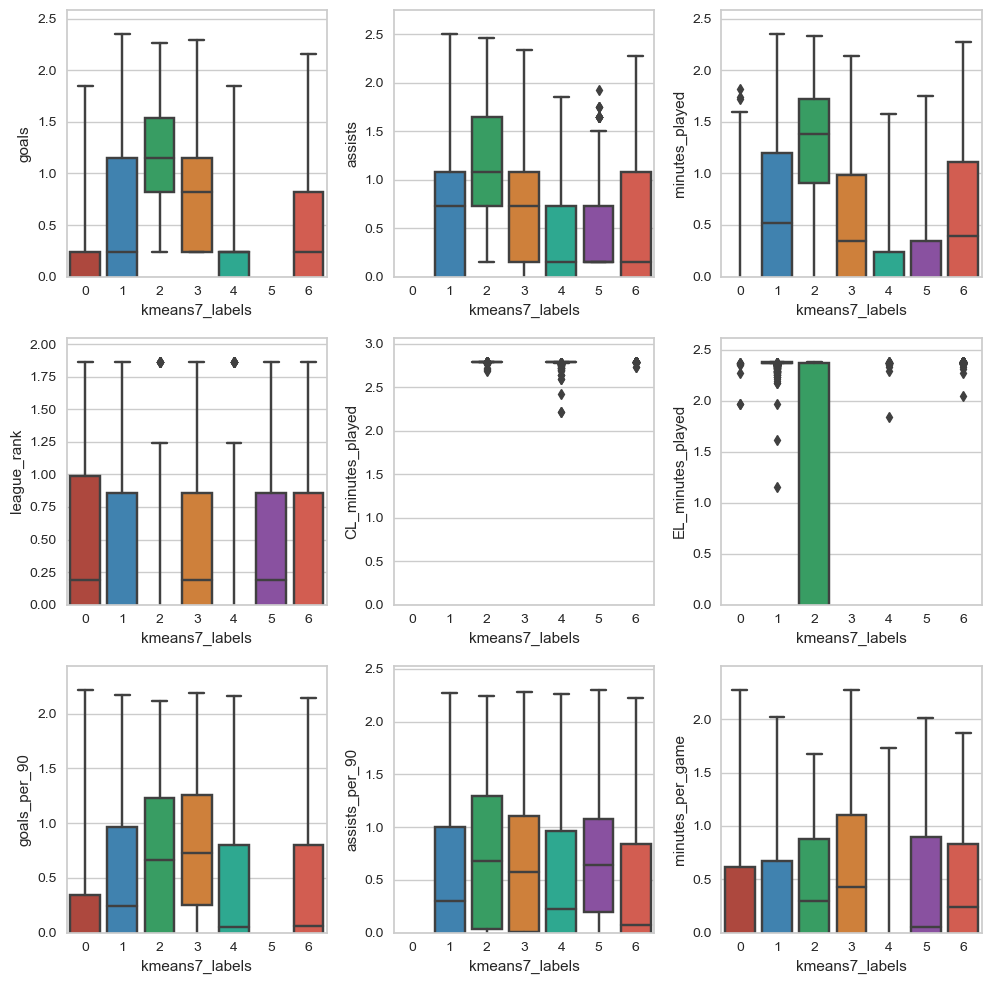

In [31]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharey=False)

for i in range(3):
    for j in range(3):
        var_index = i*3 + j
        if var_index < len(vars):
            sns.boxplot(data=df_mid_labeled, x="kmeans7_labels", y=vars[var_index], ax=ax[i, j], palette=colors)
            ax[i, j].set_ylim(0, np.max(df_mid_labeled[vars[var_index]]) * 1.1)
        else:
            ax[i, j].set_axis_off()

plt.tight_layout()
plt.show();

Having looked at boxplots of cluster for every feature in the dataset, we can see that there are indeed differences between clusters. 

### 4. Agglomerative Clustering

Our second clustering method is agglomerative/hierarchical clustering, which groups data points based on their similarity or dissimilarity. We want to plot dendrograms for hierarchical clustering with 4 types of linkage. 

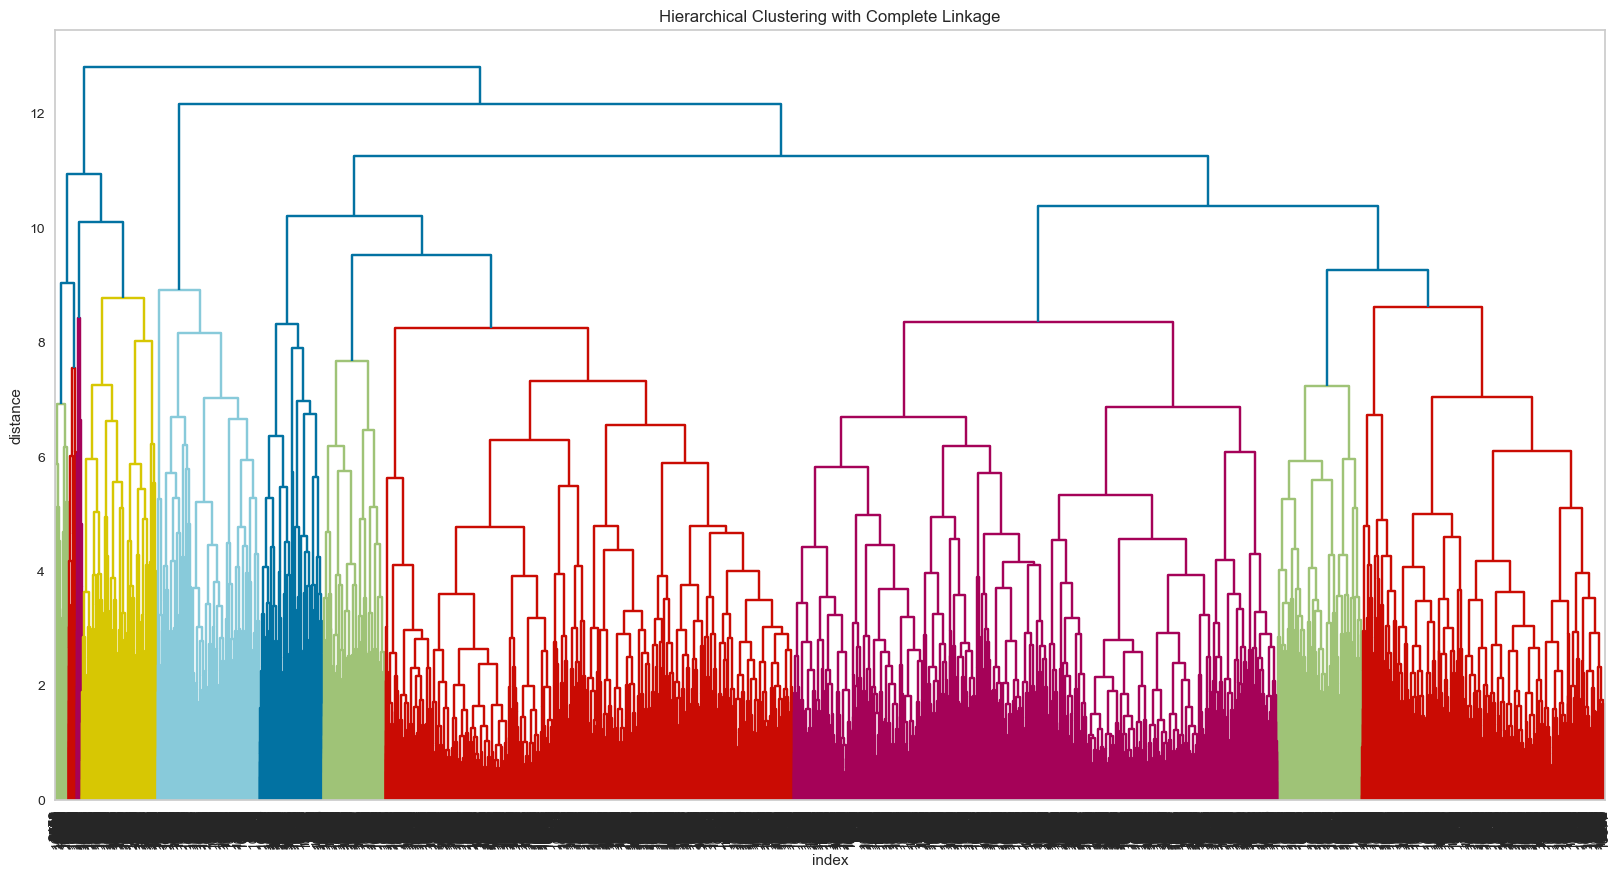

In [32]:
#complete
hc_complete = shc.linkage(df_pca, method = 'complete')
plt.figure(figsize=(20,10))
plt.title("Hierarchical Clustering with Complete Linkage")
plt.xlabel("index")
plt.ylabel("distance")
plt.grid(visible=None)
d = shc.dendrogram(hc_complete, leaf_font_size=10);

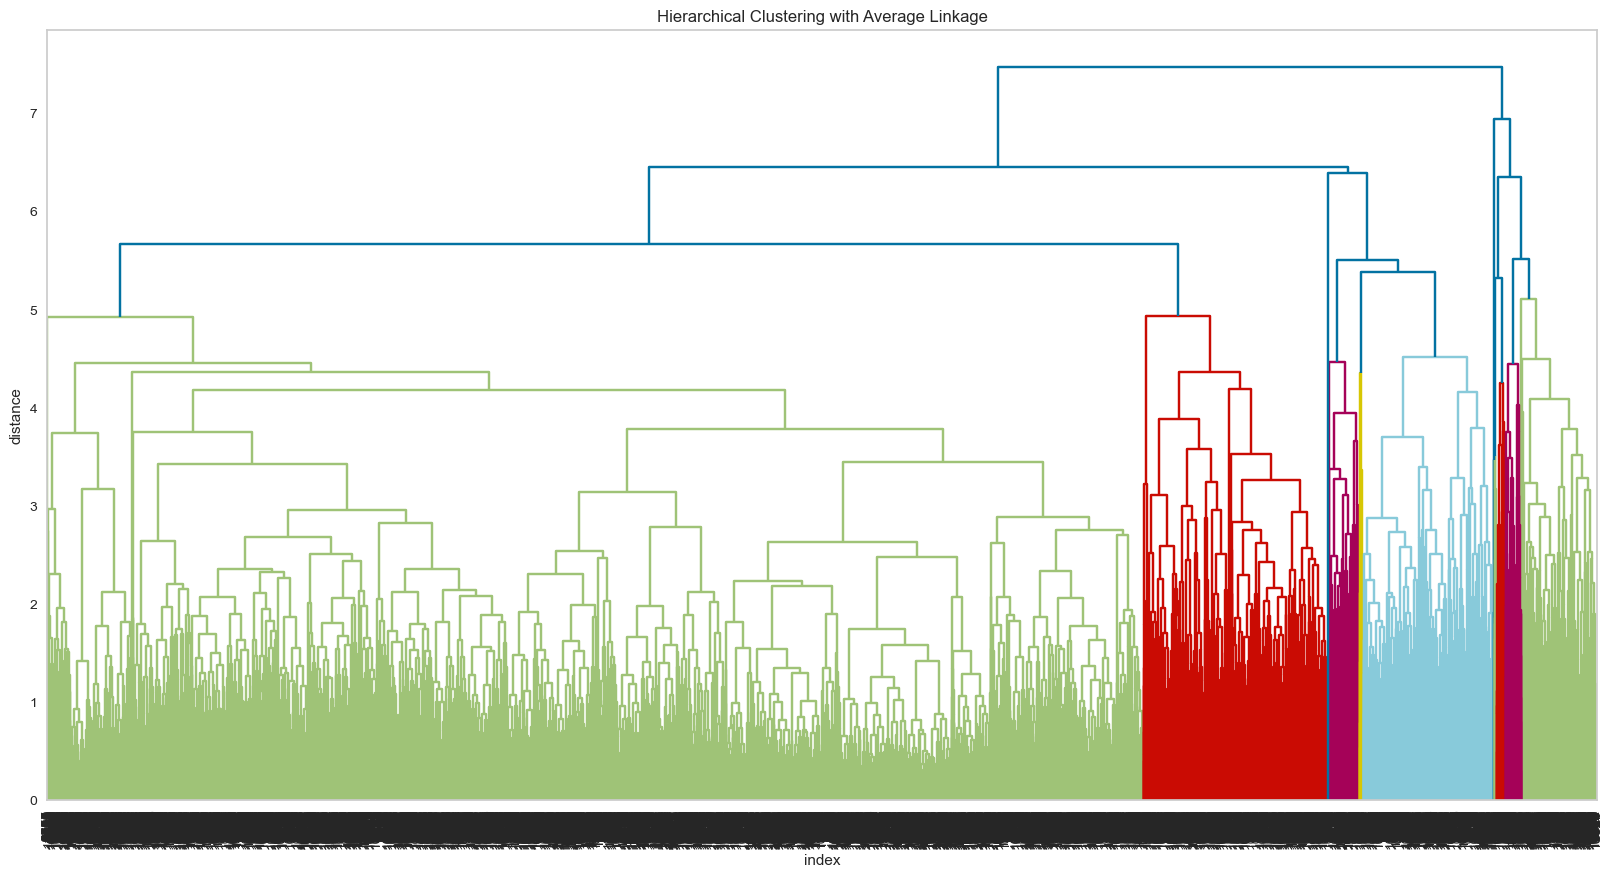

In [33]:
#average
hc_average = shc.linkage(df_pca, method = 'average')
plt.figure(figsize=(20,10))
plt.title("Hierarchical Clustering with Average Linkage")
plt.xlabel("index")
plt.ylabel("distance")
plt.grid(visible=None)
d = shc.dendrogram(hc_average, leaf_font_size=10);

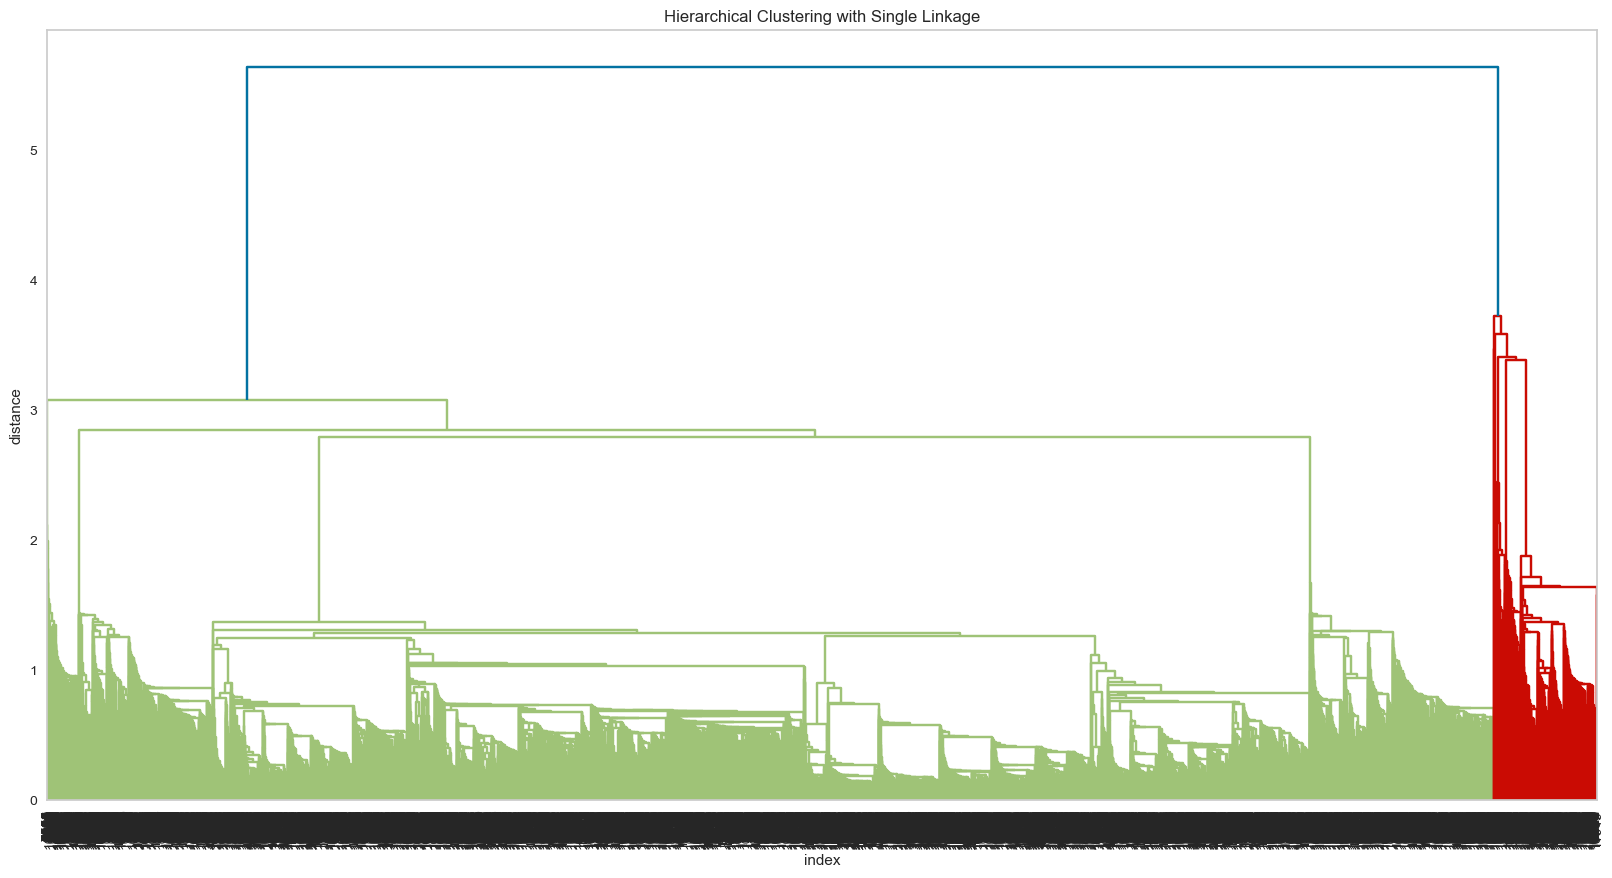

In [34]:
#linkage: single
hc_single = shc.linkage(df_pca, method = 'single')
plt.figure(figsize=(20,10))
plt.title("Hierarchical Clustering with Single Linkage")
plt.xlabel("index")
plt.ylabel("distance")
plt.grid(visible=None)
d = shc.dendrogram(hc_single, leaf_font_size=10);

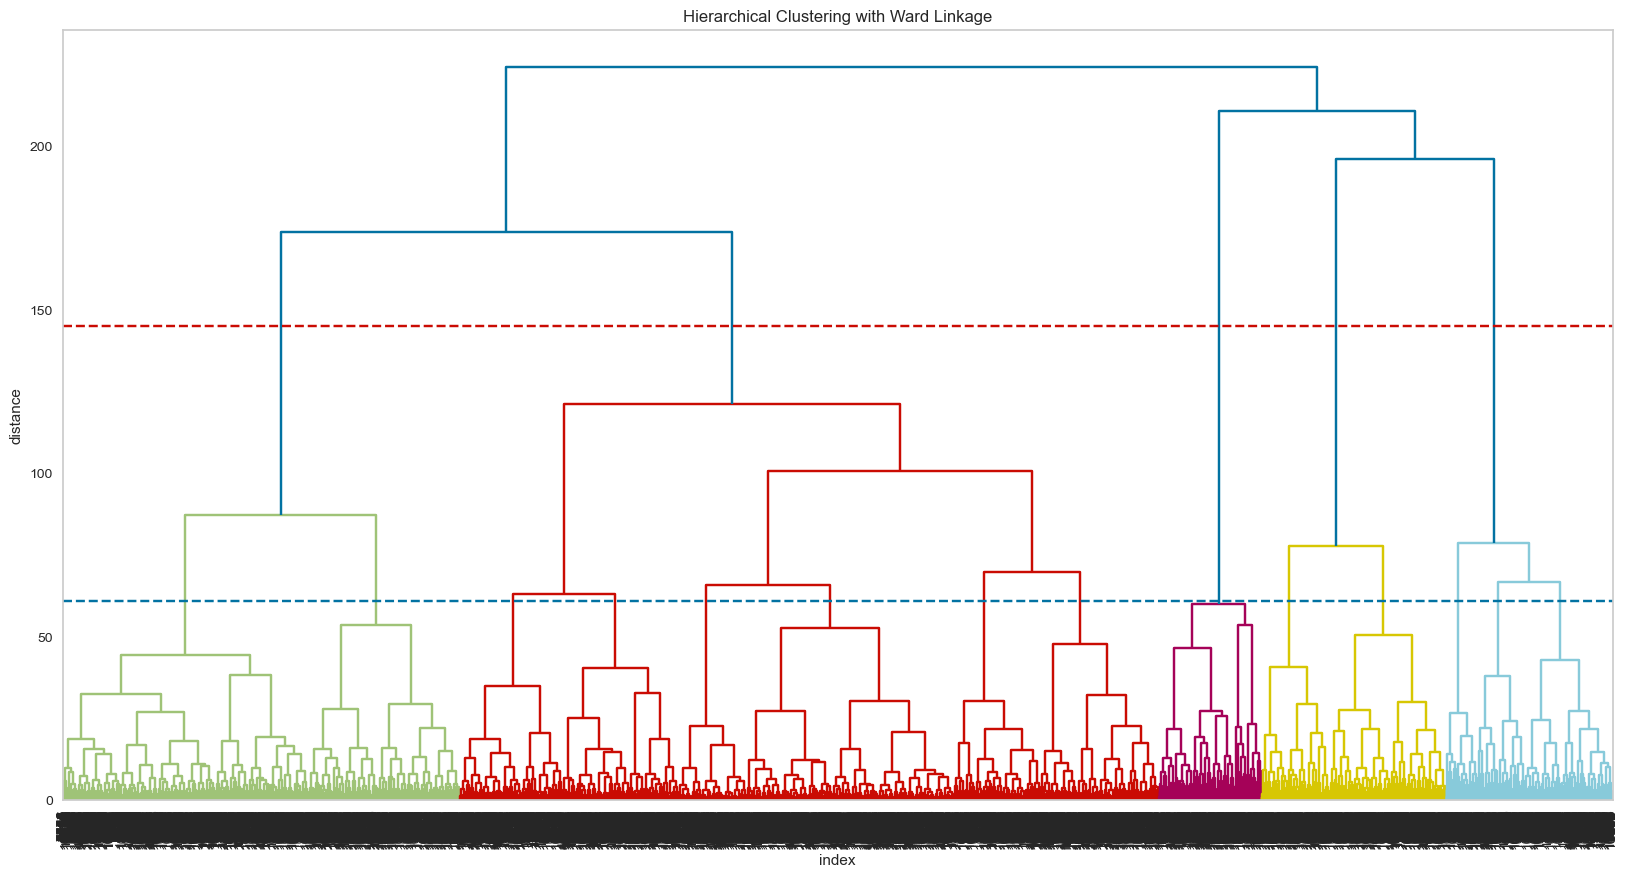

In [35]:
#ward
hc_ward = shc.linkage(df_pca, method = 'ward')
plt.figure(figsize=(20,10))
plt.title("Hierarchical Clustering with Ward Linkage")
plt.xlabel("index")
plt.ylabel("distance")
plt.grid(visible=None)
d = shc.dendrogram(hc_ward, leaf_font_size=10)
plt.axhline(y =145, color = 'r', linestyle = '--')
plt.axhline(y =61, color = 'b', linestyle = '--');

Among 4 types of linkages, the dendrogram for ward linkage allows to observe possible number of clusters. Cutting the longest branch we may get up to 14 clusters (blue dashed line) or we can settle with a moderate number of clusters, k = 5 (red dashed line). 

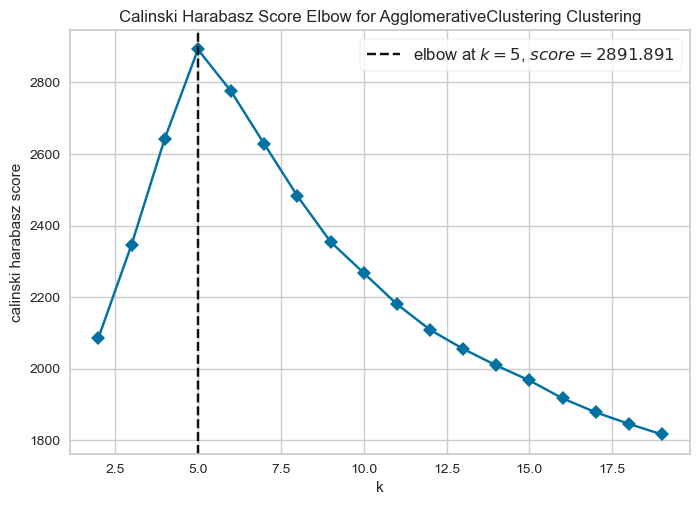

In [36]:
agg = AgglomerativeClustering(linkage='ward', metric='euclidean')
visualizer = KElbowVisualizer(agg, k=(2,20), metric='calinski_harabasz', timings=False, locate_elbow=True)
visualizer.fit(df_pca)
visualizer.show();

Checking for the best number of clusters based on Calinski-Harabasz method, we see that k = 5. We can also check the silhouette scores for different k's

In [37]:
n_clusters = range(2,15)
for i in n_clusters:
    clusters = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters = i)
    clusters.fit(df_pca)
    print("k = ",i,"- silhouette score = ", silhouette_score(df_pca, clusters.labels_),"\n")

k =  2 - silhouette score =  0.2826516421524875 

k =  3 - silhouette score =  0.3088214508573847 

k =  4 - silhouette score =  0.33290346562848633 

k =  5 - silhouette score =  0.24574321760647966 

k =  6 - silhouette score =  0.23142780771277643 

k =  7 - silhouette score =  0.24181025094093406 

k =  8 - silhouette score =  0.23304435123276288 

k =  9 - silhouette score =  0.2410214200235413 

k =  10 - silhouette score =  0.24337952314971334 

k =  11 - silhouette score =  0.2313322447783898 

k =  12 - silhouette score =  0.23175034162732766 

k =  13 - silhouette score =  0.21779927998692822 

k =  14 - silhouette score =  0.2201552921203007 



Agglomerative clustering with k = 4 has the highest silhouette score.

Let's see how spread the data is with 4 and 5 clusters in the result of agglomerative clustering.

In [38]:
hc_ward4=AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=4)
hc_ward4.fit(df_pca)

AgglomerativeClustering(metric='euclidean', n_clusters=4)

In [39]:
hc_ward5=AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc_ward5.fit(df_pca)

AgglomerativeClustering(metric='euclidean', n_clusters=5)

In [40]:
df_mid_labeled['HC4_labels'] = hc_ward4.labels_
df_mid_labeled['HC5_labels'] = hc_ward5.labels_
df_mid_labeled.head()

goals   assists  yellow_cards  red_cards  minutes_played  games_played  \
0 -1.089648  0.731045     -0.567848   -0.26645        0.431078      0.172577   
1  0.243365 -1.136827     -0.125782   -0.26645       -0.683255     -0.939658   
2 -1.089648 -1.136827     -1.145662   -0.26645       -1.170264     -0.764298   
3  0.243365  0.150293     -0.125782   -0.26645       -0.119217      0.172577   
4  0.243365  0.150293      0.236721   -0.26645        0.357598     -0.179158   

   league_rank  CL_minutes_played  CL_games_played  EL_minutes_played  ...  \
0    -0.522528           2.784858         2.787548          -0.422041  ...   
1    -0.522528          -0.359504        -0.359510          -0.422041  ...   
2    -0.522528           2.782757         2.776403          -0.422041  ...   
3    -0.522528           2.780627         2.776403          -0.422041  ...   
4     0.187829          -0.359504        -0.359510          -0.422041  ...   

        PC3       PC4       PC5       PC6       PC7  kmeans3_labels  \
0  0.503043  3.117083  1.208583 -1.896442 -0.895896               2   
1 -0.063447  0.163370 -0.490481  1.476306 -0.195767               0   
2  0.120402  3.664053  2.614922  0.115222 -0.839624               2   
3  0.483852  3.153542  1.361990  0.468523  0.199827               2   
4  0.172752 -0.314049 -1.521067 -0.250968 -0.585523               0   

   kmeans5_labels  kmeans7_labels  HC4_labels  HC5_labels  
0               4               4           1           4  
1               0               0           0           0  
2               4               4           1           4  
3               4               4           1           4  
4               3               3           0           1  

[5 rows x 28 columns]

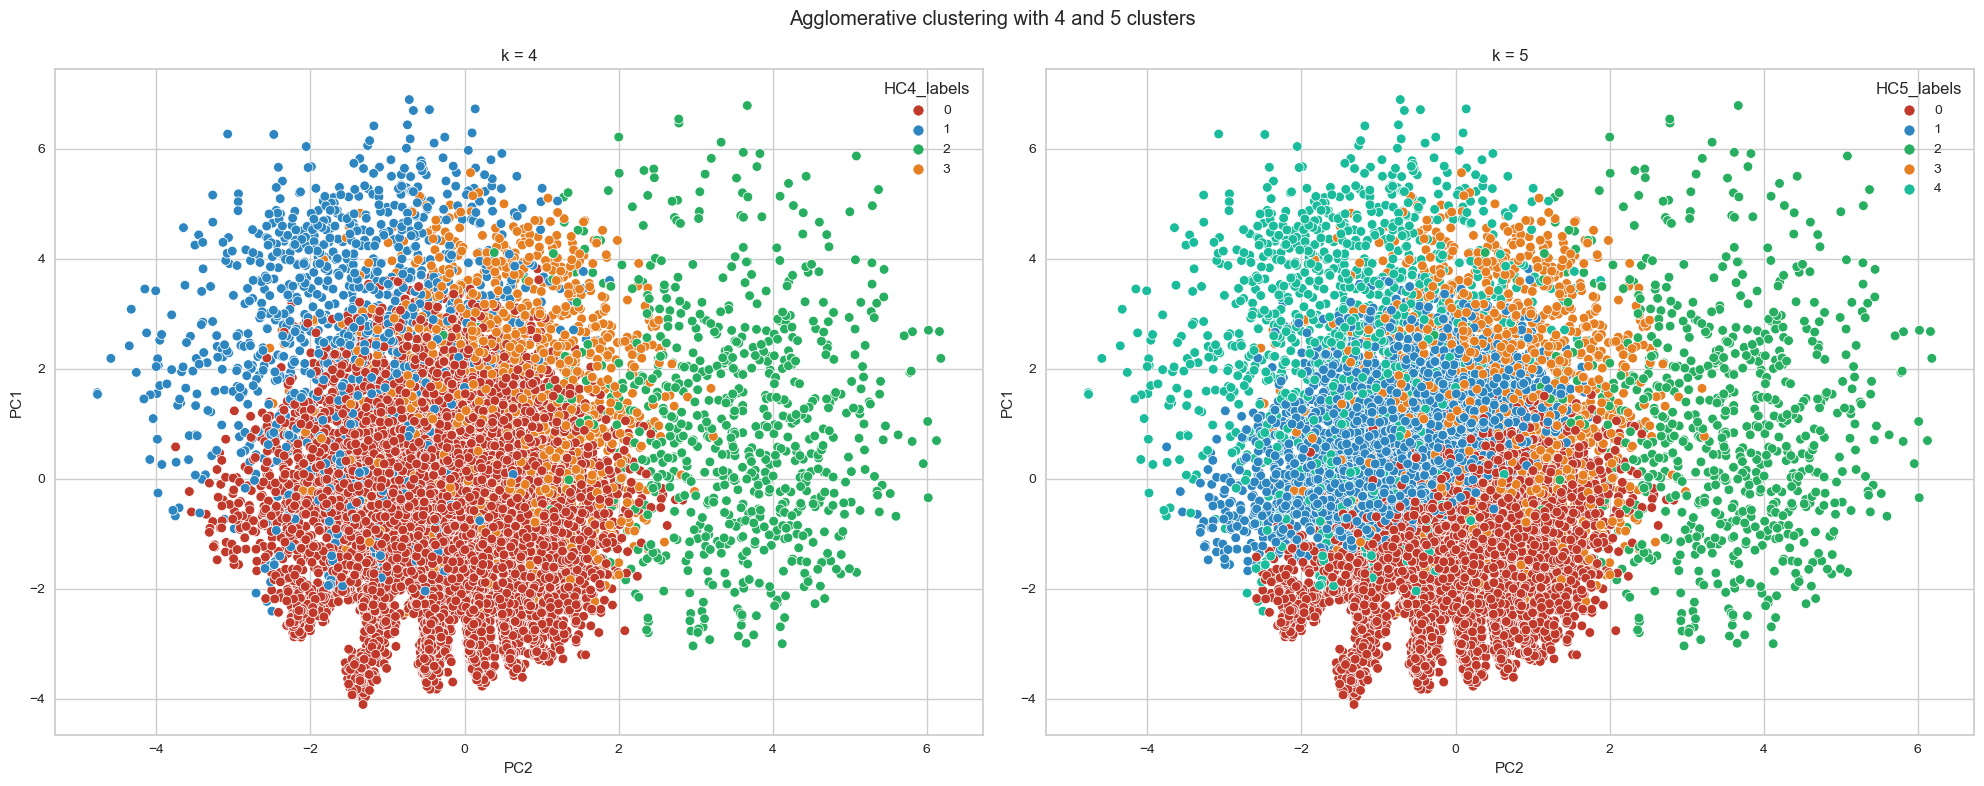

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.suptitle('Agglomerative clustering with 4 and 5 clusters')
sns.scatterplot(data=df_mid_labeled, x=df_mid_labeled['PC2'], y=df_mid_labeled['PC1'], hue=df_mid_labeled['HC4_labels'], palette=colors[:4], ax=axes[0])
axes[0].set_title('k = 4')
sns.scatterplot(data=df_mid_labeled, x=df_mid_labeled['PC2'], y=df_mid_labeled['PC1'], hue=df_mid_labeled['HC5_labels'], palette=colors[:5], ax=axes[1])
axes[1].set_title('k = 5')

plt.tight_layout()
plt.show();

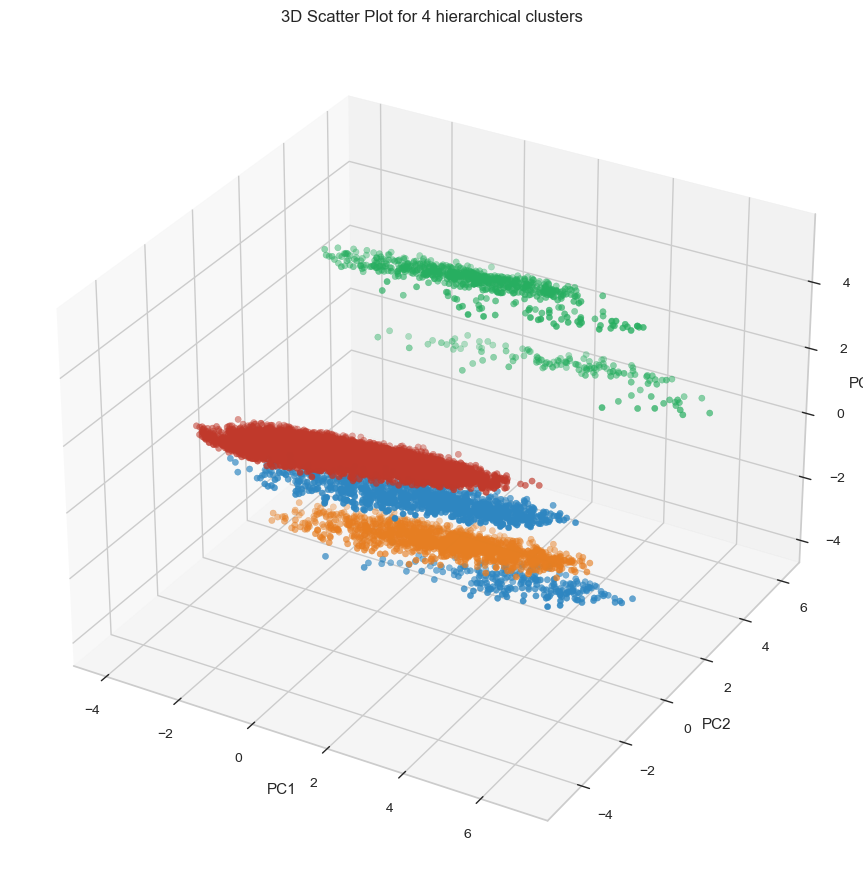

In [42]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

x = df_mid_labeled['PC1']
y = df_mid_labeled['PC2']
z = df_mid_labeled['PC3']
c = df_mid_labeled['HC4_labels']

ax.scatter(x, y, z, c=[colors[i] for i in c])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot for 4 hierarchical clusters')

plt.tight_layout()
plt.show()

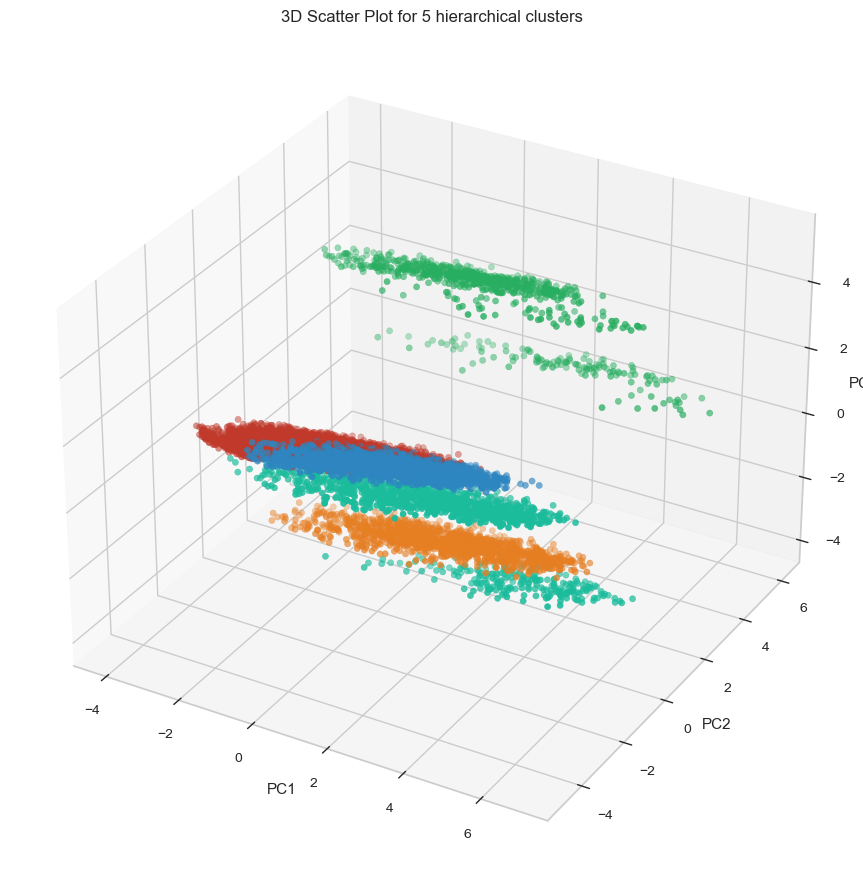

In [43]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

x = df_mid_labeled['PC1']
y = df_mid_labeled['PC2']
z = df_mid_labeled['PC3']
c = df_mid_labeled['HC5_labels']

ax.scatter(x, y, z, c=[colors[i] for i in c])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot for 5 hierarchical clusters')

plt.tight_layout()
plt.show()

#### Agglomerative CLustering: Validation

Now that we have 2 models of clustering using Agglomerative Clustering (k = 4, 5), we can validate if the clusters are well-separated and meaningful. 

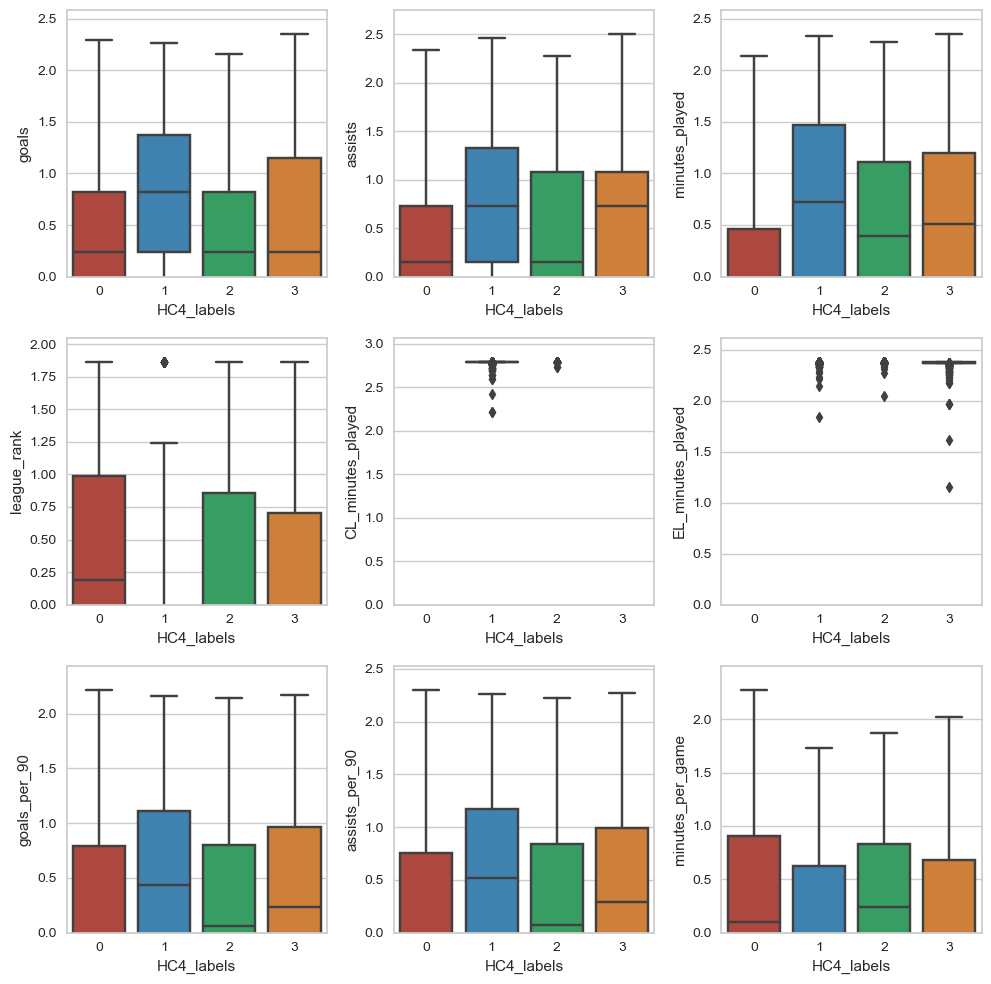

In [44]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharey=False)

for i in range(3):
    for j in range(3):
        var_index = i*3 + j
        if var_index < len(vars):
            sns.boxplot(data=df_mid_labeled, x="HC4_labels", y=vars[var_index], ax=ax[i, j], palette=colors)
            ax[i, j].set_ylim(0, np.max(df_mid_labeled[vars[var_index]]) * 1.1)
        else:
            ax[i, j].set_axis_off()

plt.tight_layout()
plt.show();

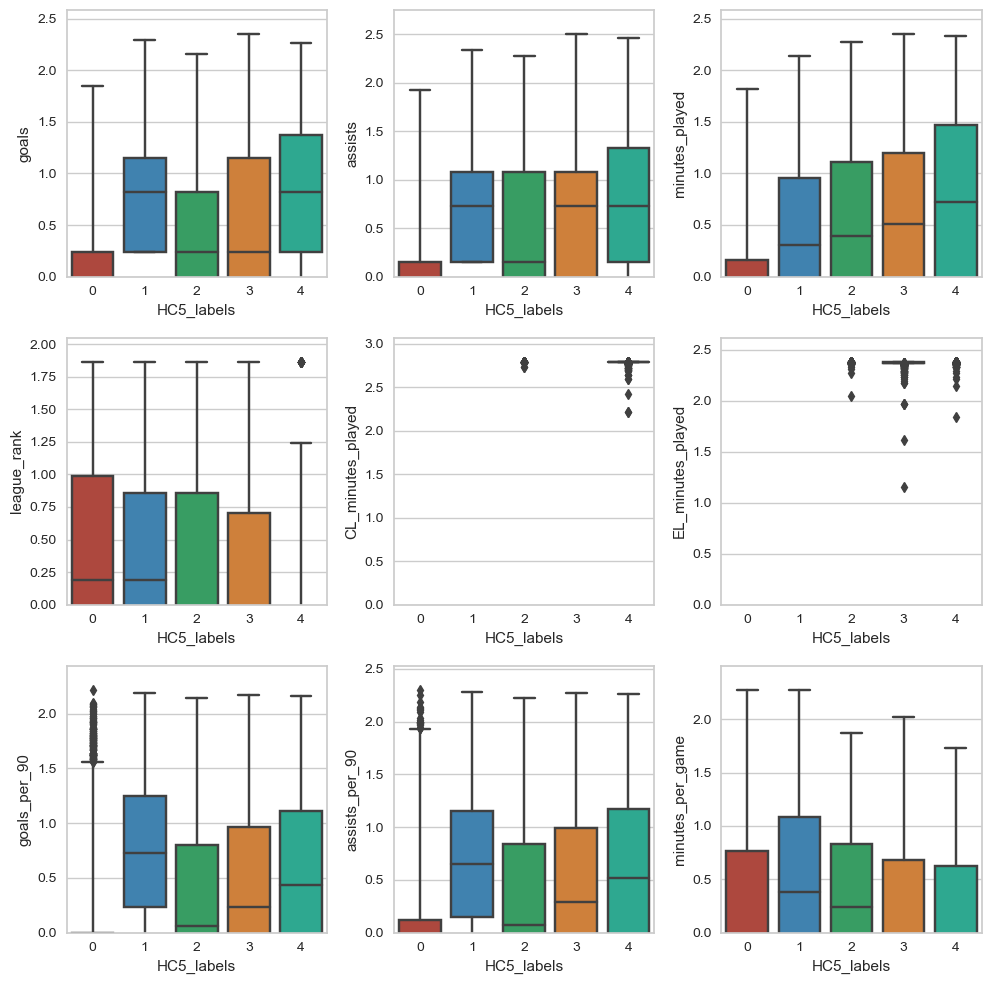

In [45]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharey=False)

for i in range(3):
    for j in range(3):
        var_index = i*3 + j
        if var_index < len(vars):
            sns.boxplot(data=df_mid_labeled, x="HC5_labels", y=vars[var_index], ax=ax[i, j], palette=colors)
            ax[i, j].set_ylim(0, np.max(df_mid_labeled[vars[var_index]]) * 1.1)
        else:
            ax[i, j].set_axis_off()

plt.tight_layout()
plt.show();

Although there are some differences between clusters, looks like agglomerative clustering has not done a good job of distinguishing the data points into separate, significantly different groups.

### 5. DBSCAN

DBSCAN is a density-based clustering algorithm used to identify clusters of varying shape and size with in a data set (Ester et al. 1996). Advantages of DBSCAN over other clustering algorithms:
- does not require a pre-determined set number of clusters
- identifies outliers as noise, instead of classifying them into a cluster.
- more flexible when it comes to the size and shape of clusters than other partitioning methods, such as K-means. It is able to identify clusters that differ in size and shape from one another, which makes it more useful for messy, real life data.

DBSCAN has two parameters. The first is ε, epsilon (“esp”), which defines the maximum distance allowed between two points within the same cluster. The second is minimum samples (“MinPts”), which defines the minimum number of data points required to form a distinct cluster.

#### Hyperparameter tuning for DBSCAN

As mentioned earlier, DBSCAN has two basic parameters, ε and min_samples. Common practice for datasets with multiple dimensions is to use min_samples = 2 * number of features. Since our PCA dataset has 7 principal components, we can set min_samples equal to 14. Having set the min_samples parameter, we can find the optimal value for ε using the elbow method based on k-nearest neighbor distances.

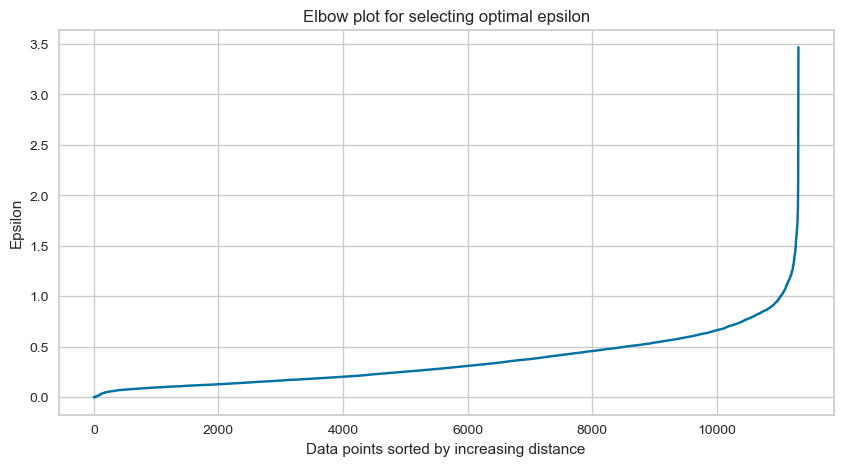

In [46]:
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=13).fit(df_pca)
distances, idx = nn.kneighbors(df_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('Elbow plot for selecting optimal epsilon')
plt.xlabel('Data points sorted by increasing distance')
plt.ylabel('Epsilon')
plt.show();

The steepest part of the curve is between (approximately) eps 0.7 and 1.7. We can check number of clusters and cluster sizes for each value of epsilon in this range.  

In [47]:
for eps in [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=14)
    labels = dbscan.fit_predict(df_pca)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=0.7
Number of clusters: 33
Cluster sizes: [4799  640  428 1539  724  379  161  337   38  146  370  269   31  391
  346   82   61  133   25   23   34   86   36   16   22   46   34   39
   14   22   15   14   14]

eps=0.8
Number of clusters: 22
Cluster sizes: [3552 1216 2380 1918 1427   74  163  111   42  110   25   38   29   42
   42   20   42   25   16   14   14   14]

eps=0.9
Number of clusters: 23
Cluster sizes: [2630 1260   17 2602 1922 1458  336  162  118  163   63  125   37   43
  119   71   48   26   33   33   21   13   14]

eps=1.0
Number of clusters: 22
Cluster sizes: [1789 1400   54 2850 1923  181 1467  549  380  121   31  165   61  146
   88    9   31   16   14   15   10   14]

eps=1.1
Number of clusters: 21
Cluster sizes: [1246   14 1411   64  494 2887 2090   29  210 1593  638   44   76  158
  137   31   48   40   80   14   10]

eps=1.2
Number of clusters: 20
Cluster sizes: [ 862  112 1415   67  552 2896 2090   64  161  214 1595  684   89  171
  160   70   14   69   15 

Some of the epsilon values result in very high numbers of clusters with some clusters consisting too few data points. The optimal model could be at eps = 1.6, where the number of clusters is 7 (including the "cluster" of outliers) and most clusters have significant amount of data points. We can check that using the solhouette score metric.

In [48]:
from itertools import product
pca_eps_values = np.arange(1.0,1.6,0.1) 
pca_min_samples = np.arange(12,18,2) 
pca_dbscan_params = list(product(pca_eps_values, pca_min_samples))
pca_no_of_clusters = []
pca_sil_score = []
pca_epsvalues = []
pca_min_samp = []
for p in pca_dbscan_params:
    pca_dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1]).fit(df_pca)
    pca_epsvalues.append(p[0])
    pca_min_samp.append(p[1])
    pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster.labels_)))
    pca_sil_score.append(silhouette_score(df_pca, pca_dbscan_cluster.labels_))
pca_eps_min = list(zip(pca_no_of_clusters, pca_sil_score, pca_epsvalues, pca_min_samp))
pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['no_of_clusters', 'silhouette_score', 'epsilon_values', 'minimum_points'])
pca_eps_min_df

no_of_clusters  silhouette_score  epsilon_values  minimum_points
0               21          0.123754             1.0              12
1               22          0.097304             1.0              14
2               18          0.080026             1.0              16
3               22          0.171897             1.1              12
4               21          0.162880             1.1              14
5               19          0.154562             1.1              16
6               22          0.191877             1.2              12
7               20          0.187766             1.2              14
8               17          0.188554             1.2              16
9               17          0.192461             1.3              12
10              16          0.182712             1.3              14
11              15          0.195867             1.3              16
12               7          0.287239             1.4              12
13               8          0.268507             1.4              14
14               9          0.234230             1.4              16
15               7          0.315194             1.5              12
16               8          0.303749             1.5              14
17               8          0.274046             1.5              16
18               8          0.318147             1.6              12
19               7          0.317981             1.6              14
20               7          0.315938             1.6              16

Epsilon of 1.6 with 14 minimum samples give 7 clusters with the highest silhouette score of 0.318.

In [49]:
db = DBSCAN(eps=1.6, min_samples=14).fit(df_pca)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Score: %0.3f" % silhouette_score(df_pca, labels))

Estimated number of clusters: 6
Estimated number of noise points: 255
Silhouette Score: 0.318


We should keep in mind that one of 7 clusters is outliers "cluster" (labeled as -1). So, actually our DBSCAN model results in 6 clusters.

In [50]:
df_mid_labeled['dbscan6_labels'] = labels
df_mid_labeled.head(20)

goals   assists  yellow_cards  red_cards  minutes_played  games_played  \
0  -1.089648  0.731045     -0.567848   -0.26645        0.431078      0.172577   
1   0.243365 -1.136827     -0.125782   -0.26645       -0.683255     -0.939658   
2  -1.089648 -1.136827     -1.145662   -0.26645       -1.170264     -0.764298   
3   0.243365  0.150293     -0.125782   -0.26645       -0.119217      0.172577   
4   0.243365  0.150293      0.236721   -0.26645        0.357598     -0.179158   
5  -1.089648 -1.136827     -0.567848   -0.26645       -0.839977     -1.130521   
6   0.243365  0.150293      0.236721   -0.26645        0.532951      0.651069   
7   0.815428 -1.136827     -0.125782   -0.26645       -1.312797     -1.829195   
8  -1.089648 -1.136827      0.236721   -0.26645       -1.201949     -1.339733   
9   0.243365  0.150293     -0.125782   -0.26645       -0.825786     -0.602200   
10 -1.089648 -1.136827     -0.125782   -0.26645        0.144538     -0.310958   
11  0.243365 -1.136827     -0.567848   -0.26645       -0.883240     -0.451572   
12 -1.089648 -1.136827     -0.567848   -0.26645       -0.698537     -0.764298   
13  0.243365 -1.136827     -0.125782   -0.26645       -1.051492     -1.339733   
14 -1.089648 -1.136827      1.060454   -0.26645        0.998046      1.106612   
15  0.243365 -1.136827     -0.125782   -0.26645       -1.564200     -0.939658   
16  0.243365 -1.136827      0.546281   -0.26645        0.285772     -0.179158   
17 -1.089648 -1.136827      1.060454   -0.26645       -0.233106     -0.939658   
18 -1.089648 -1.136827     -2.022515   -0.26645       -1.735061     -2.121070   
19  0.243365  0.731045     -1.145662   -0.26645       -0.659503     -1.339733   

    league_rank  CL_minutes_played  CL_games_played  EL_minutes_played  ...  \
0     -0.522528           2.784858         2.787548          -0.422041  ...   
1     -0.522528          -0.359504        -0.359510          -0.422041  ...   
2     -0.522528           2.782757         2.776403          -0.422041  ...   
3     -0.522528           2.780627         2.776403          -0.422041  ...   
4      0.187829          -0.359504        -0.359510          -0.422041  ...   
5      1.120917          -0.359504        -0.359510          -0.422041  ...   
6      1.120917          -0.359504        -0.359510          -0.422041  ...   
7     -0.254495          -0.359504        -0.359510          -0.422041  ...   
8     -0.254495          -0.359504        -0.359510          -0.422041  ...   
9      1.242996          -0.359504        -0.359510          -0.422041  ...   
10    -0.522528          -0.359504        -0.359510          -0.422041  ...   
11     1.120917           2.784873         2.788094          -0.422041  ...   
12     1.120917          -0.359504        -0.359510          -0.422041  ...   
13    -0.522528          -0.359504        -0.359510          -0.422041  ...   
14    -0.522528          -0.359504        -0.359510           2.373236  ...   
15    -0.522528          -0.359504        -0.359510           2.365886  ...   
16     0.376037          -0.359504        -0.359510          -0.422041  ...   
17     0.376037          -0.359504        -0.359510          -0.422041  ...   
18    -0.522528           2.782451         2.776403          -0.422041  ...   
19    -0.522528          -0.359504        -0.359510          -0.422041  ...   

         PC4       PC5       PC6       PC7  kmeans3_labels  kmeans5_labels  \
0   3.117083  1.208583 -1.896442 -0.895896               2               4   
1   0.163370 -0.490481  1.476306 -0.195767               0               0   
2   3.664053  2.614922  0.115222 -0.839624               2               4   
3   3.153542  1.361990  0.468523  0.199827               2               4   
4  -0.314049 -1.521067 -0.250968 -0.585523               0               3   
5   0.222055 -0.127704 -0.133223 -0.527696               0               0   
6  -0.271932 -0.927343  0.015734 -0.090092               0               3   
7  -0.199957 -0.80464

As before, we add a new column with DBSCAN labels to the original dataset.

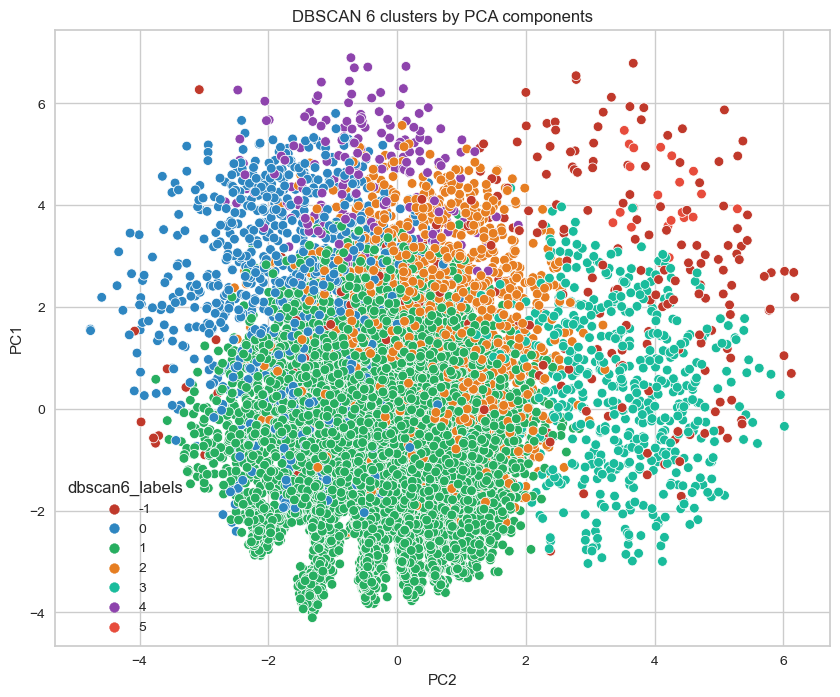

In [51]:
dbscan = DBSCAN(eps = 1.6, min_samples = 14)
clusters = dbscan.fit_predict(df_pca)
plt.figure(figsize = (10, 8))
sns.scatterplot(data=df_mid_labeled, x=df_mid_labeled['PC2'], y=df_mid_labeled['PC1'], hue=df_mid_labeled['dbscan6_labels'], palette=colors[:7])
plt.title('DBSCAN 6 clusters by PCA components')
plt.show();

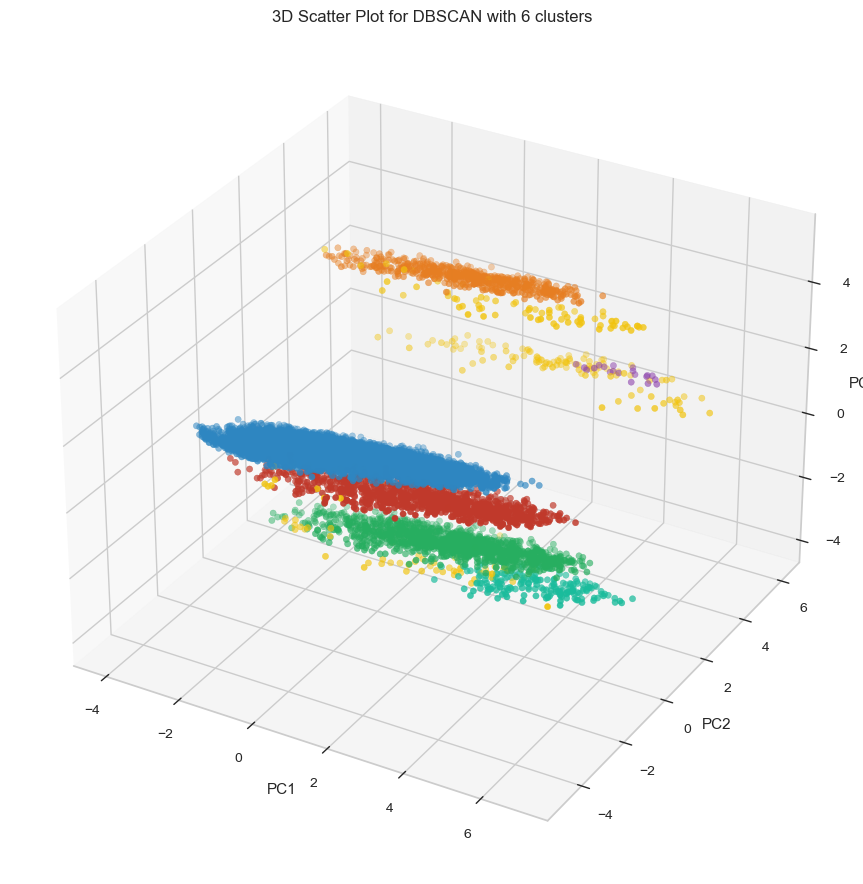

In [52]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

x = df_mid_labeled['PC1']
y = df_mid_labeled['PC2']
z = df_mid_labeled['PC3']
c = df_mid_labeled['dbscan6_labels']

ax.scatter(x, y, z, c=[colors[i] for i in c])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot for DBSCAN with 6 clusters')

plt.tight_layout()
plt.show();

#### DBSCAN: Validation

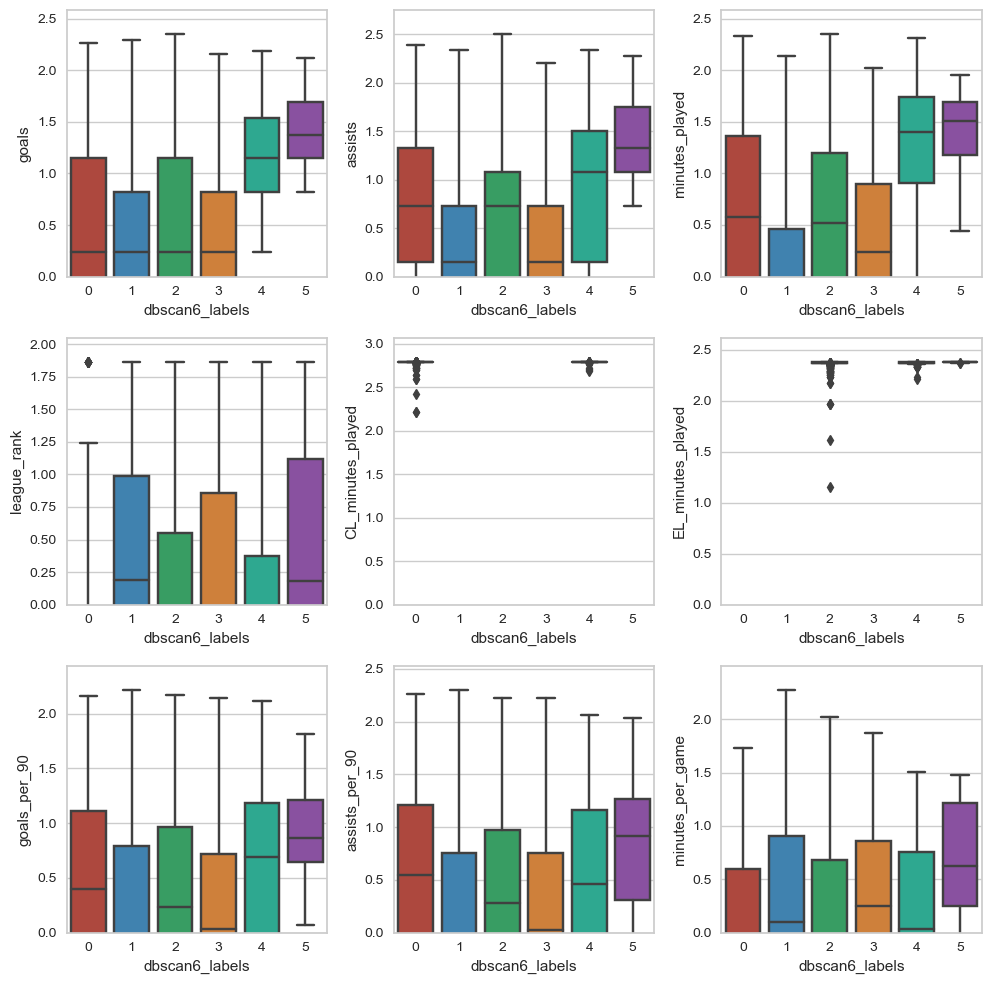

In [53]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharey=False)

for i in range(3):
    for j in range(3):
        var_index = i*3 + j
        if var_index < len(vars):
            sns.boxplot(data=df_mid_labeled[df_mid_labeled['dbscan6_labels'] != -1], x="dbscan6_labels", y=vars[var_index], ax=ax[i, j], palette=colors)
            ax[i, j].set_ylim(0, np.max(df_mid_labeled[vars[var_index]]) * 1.1)
        else:
            ax[i, j].set_axis_off()

plt.tight_layout()
plt.show();

DBSCAN did well on separating the clusters label 4 and 5, which are different than other clusters. However, there is no observable significant difference between other clusters. 

### 6. Gaussian Mixture Models

The next model we are using for clustering is Gaussian Mixture Models, which is a [probabilistic version](https://towardsdatascience.com/gaussian-mixture-model-clearly-explained-115010f7d4cf) of KMeans. KMeans and GMM have the same starting point and training process, but they differ in their approach. KMeans uses distance-based while GMM uses a probabilistic approach. The primary assumption in GMM is that the dataset is made up of multiple Gaussians, meaning a mixture of the Gaussian. There are a few metrics used to find the optimal number of clusters. Let's start with AIC and  BIC, that are used to balance the goodness of fit against the complexity of the model.

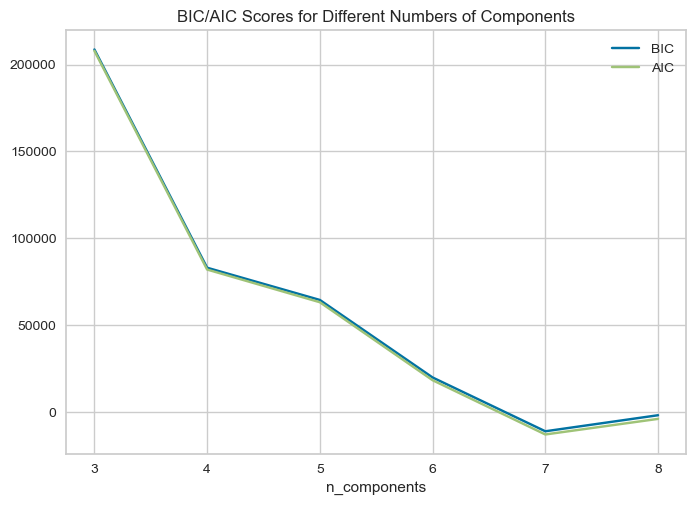

In [54]:
k_clusters = np.arange(3, 9)
models = [GaussianMixture(n, covariance_type='full', random_state=seed).fit(df_pca) for n in k_clusters]
bic = [m.bic(df_pca) for m in models]
aic = [m.aic(df_pca) for m in models]
ss = [silhouette_score(df_pca, m.predict(df_pca)) for m in models]
plt.plot(k_clusters, bic, label='BIC')
plt.plot(k_clusters, aic, label='AIC')
plt.title('BIC/AIC Scores for Different Numbers of Components')
plt.legend(loc='best')
plt.xlabel('n_components');

The best model in terms of AIC and BIC is when there are 7 clusters. How about the silhouette score for each number of clusters?

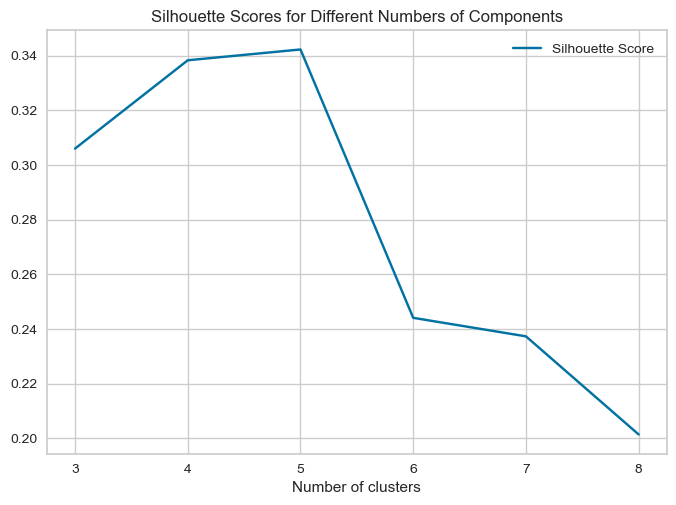

In [55]:
plt.plot(k_clusters, ss, label='Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Components')
plt.legend(loc='best')
plt.xlabel('Number of clusters');

The highest silhouette score corresponds to a model with 5 clusters.

In [56]:
for n in np.arange(3, 9):
    gmm = GaussianMixture(n, covariance_type='full', random_state=seed).fit(df_pca)
    print('n = ', n, ': ', 'aic =', gmm.aic(df_pca), ', bic =', gmm.bic(df_pca), ', silhouette score =', silhouette_score(df_pca, gmm.predict(df_pca)))

n =  3 :  aic = 207989.38074281177 , bic = 208774.0969336334 , silhouette score = 0.30594611908960695
n =  4 :  aic = 81970.11787891477 , bic = 83018.85073206891 , silhouette score = 0.33826328774813114
n =  5 :  aic = 63136.41909576417 , bic = 64449.168611250825 , silhouette score = 0.34221596307412444
n =  6 :  aic = 18214.014530706012 , bic = 19790.780708525177 , silhouette score = 0.24403626249953786
n =  7 :  aic = -13053.246431269918 , bic = -11212.46359111824 , silhouette score = 0.2372664698222984
n =  8 :  aic = -4069.836079951725 , bic = -1965.0365774675347 , silhouette score = 0.20136647034612185


While k = 5 has the highest silhouette score, its AIC/BIC scores are a bit high, too. With k = 7, we have low AIC/BIC scores, but the silhouete score is also relatively low. Let's see what Calinski-Harabasz method suggests.

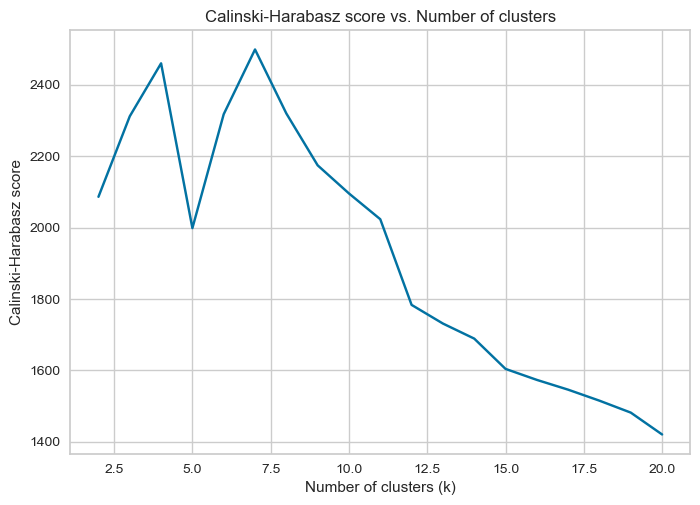

In [57]:
ch_scores = []

# calculate score for each k
for k in range(2, 21):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=seed).fit(df_pca)
    ch_scores.append(calinski_harabasz_score(df_pca, gmm.predict(df_pca)))

plt.plot(range(2, 21), ch_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz score')
plt.title('Calinski-Harabasz score vs. Number of clusters')
plt.show();

The highest Calinski-Harabasz score is achieved when the number of clusters is 7. We can try both k = 5 and 7 and see if these numbers of clusters are meaningful.

In [58]:
gmm5 = GaussianMixture(n_components=5, covariance_type='full', random_state=seed)
gmm5.fit(df_pca)

# predict the clusters
gmm5_labels = gmm5.predict(df_pca)

In [59]:
gmm7 = GaussianMixture(n_components=7, covariance_type='full', random_state=seed)
gmm7.fit(df_pca)

# predict the clusters
gmm7_labels = gmm7.predict(df_pca)

In [60]:
df_mid_labeled['GMM5_labels'] = gmm5_labels
df_mid_labeled['GMM7_labels'] = gmm7_labels

df_mid_labeled.head()

goals   assists  yellow_cards  red_cards  minutes_played  games_played  \
0 -1.089648  0.731045     -0.567848   -0.26645        0.431078      0.172577   
1  0.243365 -1.136827     -0.125782   -0.26645       -0.683255     -0.939658   
2 -1.089648 -1.136827     -1.145662   -0.26645       -1.170264     -0.764298   
3  0.243365  0.150293     -0.125782   -0.26645       -0.119217      0.172577   
4  0.243365  0.150293      0.236721   -0.26645        0.357598     -0.179158   

   league_rank  CL_minutes_played  CL_games_played  EL_minutes_played  ...  \
0    -0.522528           2.784858         2.787548          -0.422041  ...   
1    -0.522528          -0.359504        -0.359510          -0.422041  ...   
2    -0.522528           2.782757         2.776403          -0.422041  ...   
3    -0.522528           2.780627         2.776403          -0.422041  ...   
4     0.187829          -0.359504        -0.359510          -0.422041  ...   

        PC6       PC7  kmeans3_labels  kmeans5_labels  kmeans7_labels  \
0 -1.896442 -0.895896               2               4               4   
1  1.476306 -0.195767               0               0               0   
2  0.115222 -0.839624               2               4               4   
3  0.468523  0.199827               2               4               4   
4 -0.250968 -0.585523               0               3               3   

   HC4_labels  HC5_labels  dbscan6_labels  GMM5_labels  GMM7_labels  
0           1           4               0            4            4  
1           0           0               1            0            0  
2           1           4               0            4            4  
3           1           4               0            4            4  
4           0           1               1            0            3  

[5 rows x 31 columns]

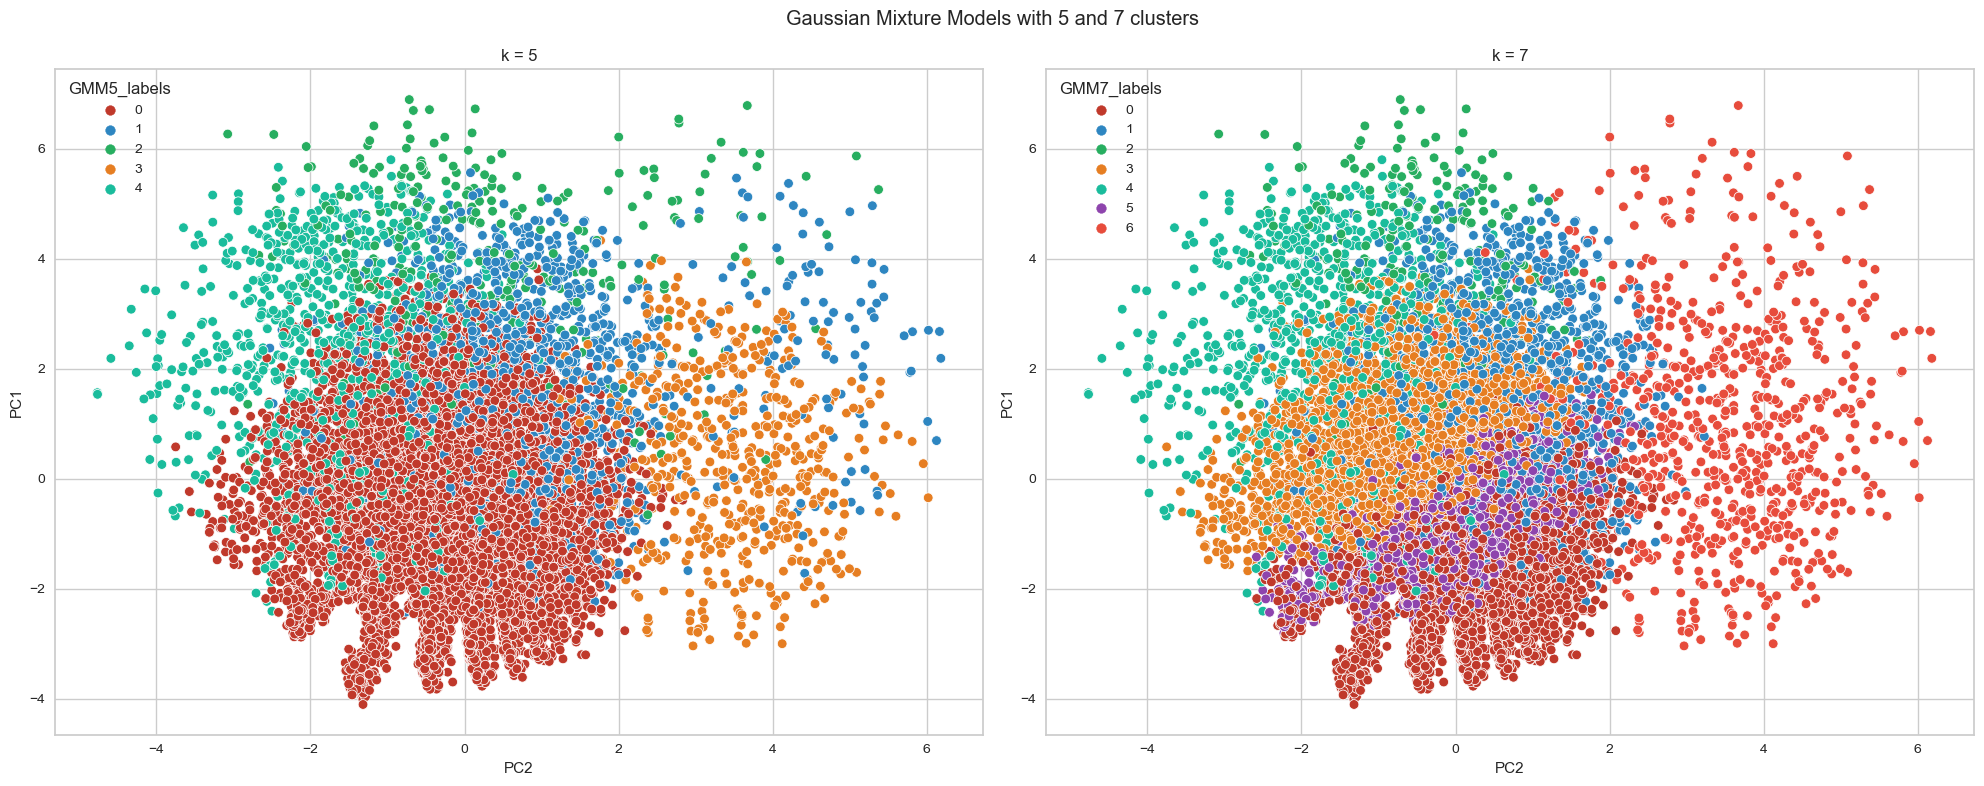

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.suptitle('Gaussian Mixture Models with 5 and 7 clusters')
sns.scatterplot(data=df_mid_labeled, x=df_mid_labeled['PC2'], y=df_mid_labeled['PC1'], hue=df_mid_labeled['GMM5_labels'], palette=colors[:5], ax=axes[0])
axes[0].set_title('k = 5')
sns.scatterplot(data=df_mid_labeled, x=df_mid_labeled['PC2'], y=df_mid_labeled['PC1'], hue=df_mid_labeled['GMM7_labels'], palette=colors[:7], ax=axes[1])
axes[1].set_title('k = 7')

plt.tight_layout()
plt.show();

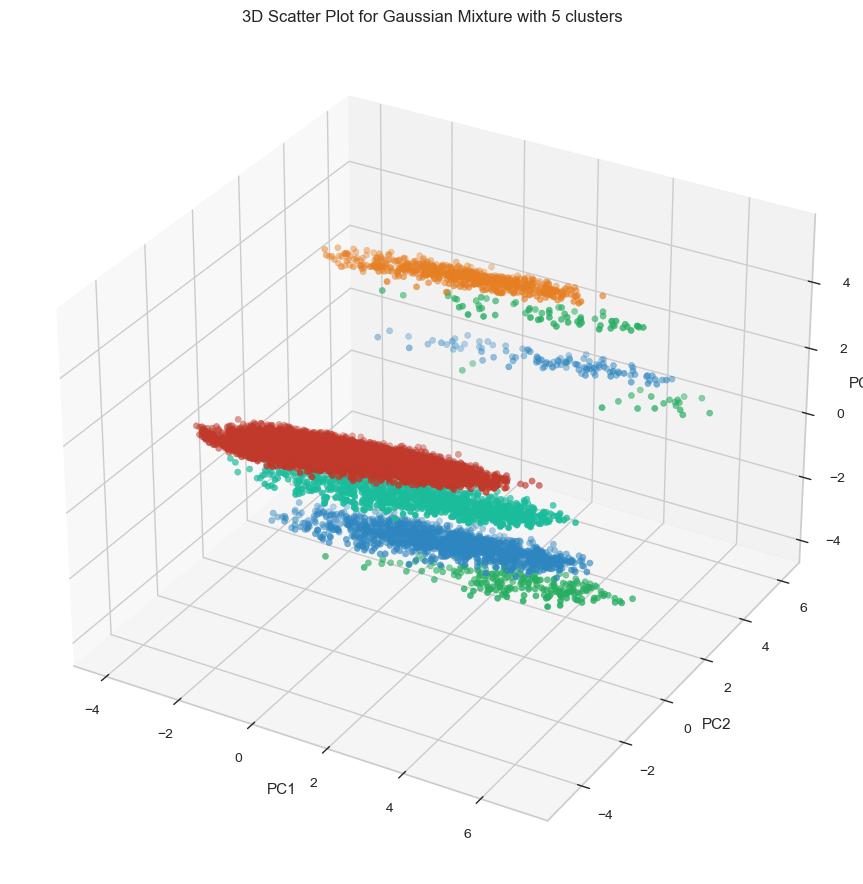

In [62]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

x = df_mid_labeled['PC1']
y = df_mid_labeled['PC2']
z = df_mid_labeled['PC3']
c = df_mid_labeled['GMM5_labels']


ax.scatter(x, y, z, c=[colors[i] for i in c])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot for Gaussian Mixture with 5 clusters')

plt.tight_layout()
plt.show();

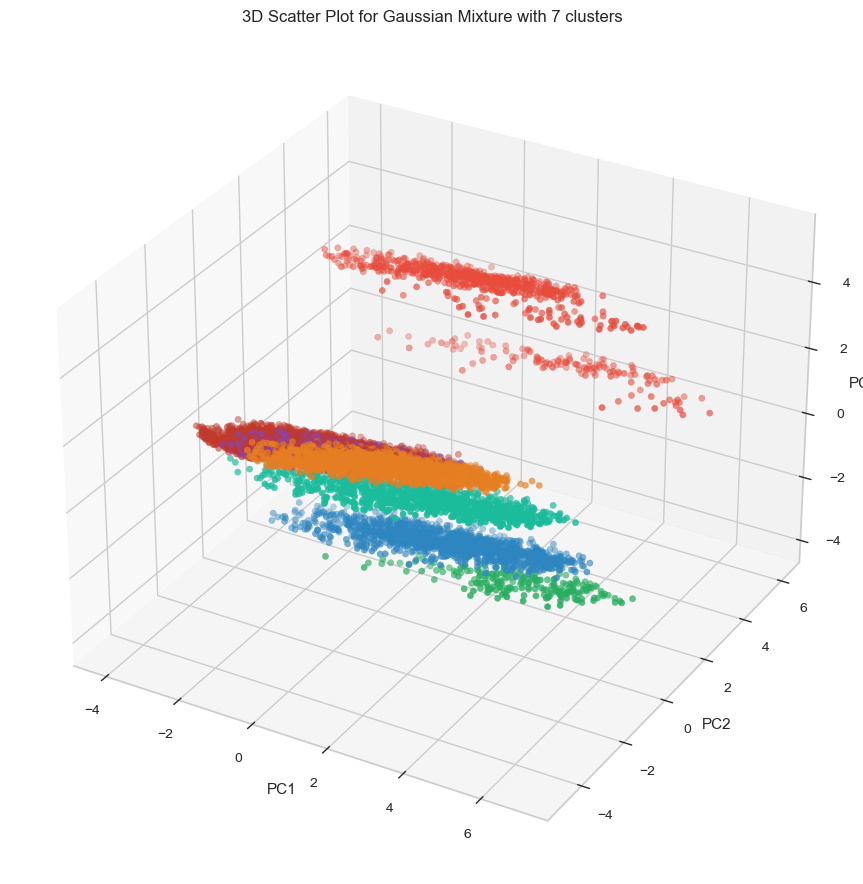

In [63]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

x = df_mid_labeled['PC1']
y = df_mid_labeled['PC2']
z = df_mid_labeled['PC3']
c = df_mid_labeled['GMM7_labels']


ax.scatter(x, y, z, c=[colors[i] for i in c])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot for Gaussian Mixture with 7 clusters')

plt.tight_layout()
plt.show();

#### Gaussian Mixture Models: Validation

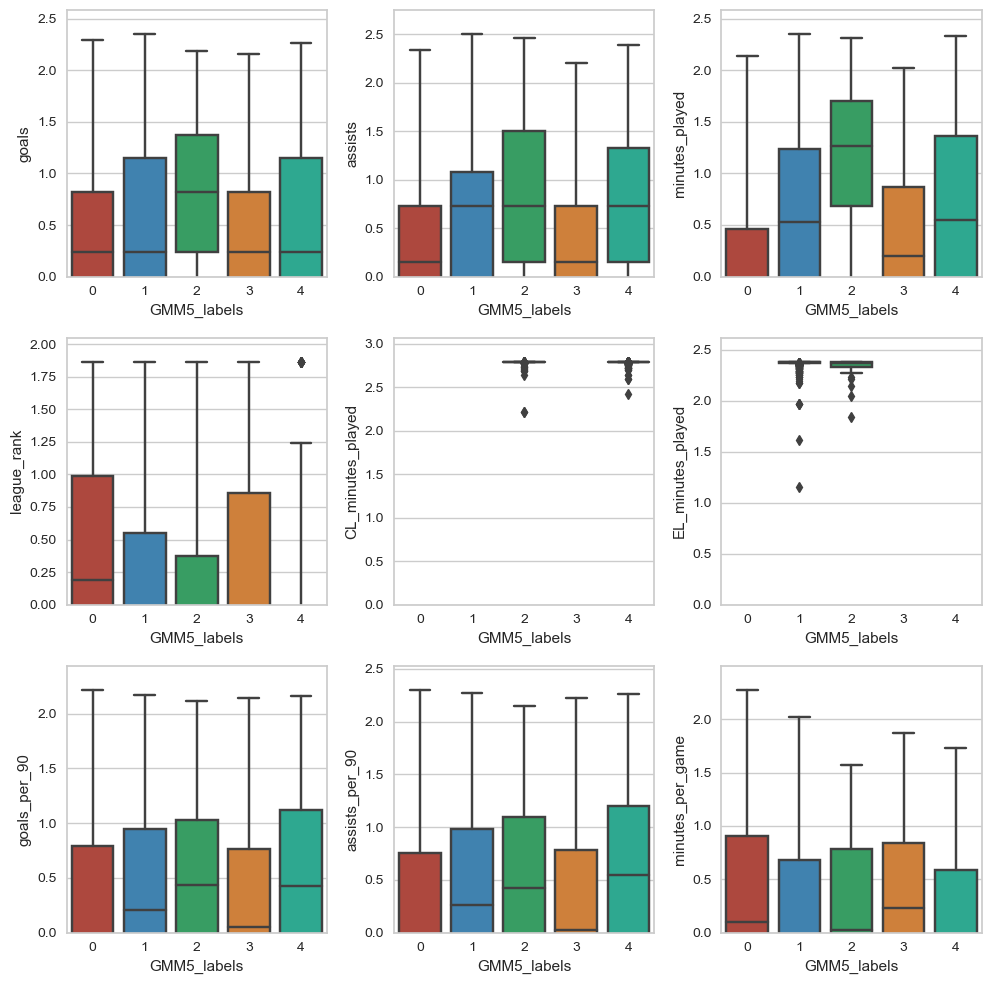

In [64]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharey=False)

for i in range(3):
    for j in range(3):
        var_index = i*3 + j
        if var_index < len(vars):
            sns.boxplot(data=df_mid_labeled, x="GMM5_labels", y=vars[var_index], ax=ax[i, j], palette=colors)
            ax[i, j].set_ylim(0, np.max(df_mid_labeled[vars[var_index]]) * 1.1)
        else:
            ax[i, j].set_axis_off()

plt.tight_layout()
plt.show();

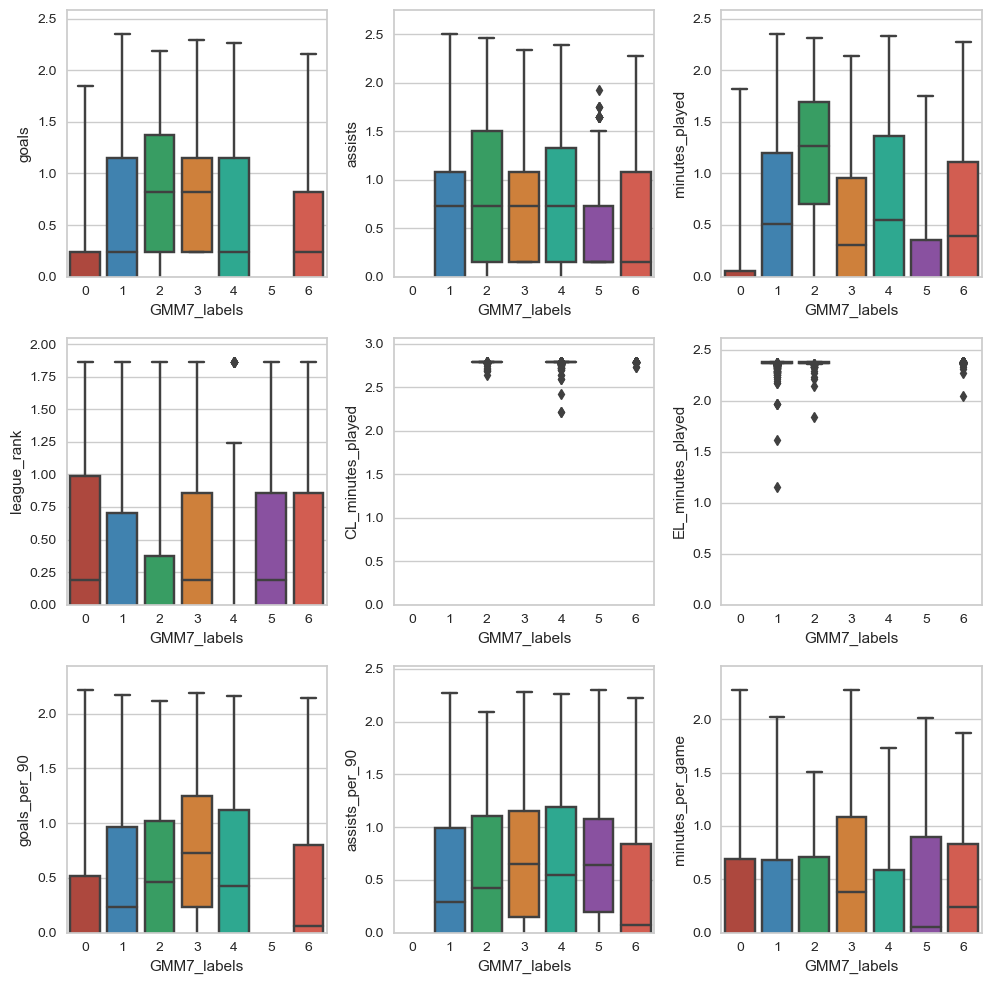

In [65]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharey=False)

for i in range(3):
    for j in range(3):
        var_index = i*3 + j
        if var_index < len(vars):
            sns.boxplot(data=df_mid_labeled, x="GMM7_labels", y=vars[var_index], ax=ax[i, j], palette=colors)
            ax[i, j].set_ylim(0, np.max(df_mid_labeled[vars[var_index]]) * 1.1)
        else:
            ax[i, j].set_axis_off()

plt.tight_layout()
plt.show();

In [66]:
df_mid_labeled.head()

goals   assists  yellow_cards  red_cards  minutes_played  games_played  \
0 -1.089648  0.731045     -0.567848   -0.26645        0.431078      0.172577   
1  0.243365 -1.136827     -0.125782   -0.26645       -0.683255     -0.939658   
2 -1.089648 -1.136827     -1.145662   -0.26645       -1.170264     -0.764298   
3  0.243365  0.150293     -0.125782   -0.26645       -0.119217      0.172577   
4  0.243365  0.150293      0.236721   -0.26645        0.357598     -0.179158   

   league_rank  CL_minutes_played  CL_games_played  EL_minutes_played  ...  \
0    -0.522528           2.784858         2.787548          -0.422041  ...   
1    -0.522528          -0.359504        -0.359510          -0.422041  ...   
2    -0.522528           2.782757         2.776403          -0.422041  ...   
3    -0.522528           2.780627         2.776403          -0.422041  ...   
4     0.187829          -0.359504        -0.359510          -0.422041  ...   

        PC6       PC7  kmeans3_labels  kmeans5_labels  kmeans7_labels  \
0 -1.896442 -0.895896               2               4               4   
1  1.476306 -0.195767               0               0               0   
2  0.115222 -0.839624               2               4               4   
3  0.468523  0.199827               2               4               4   
4 -0.250968 -0.585523               0               3               3   

   HC4_labels  HC5_labels  dbscan6_labels  GMM5_labels  GMM7_labels  
0           1           4               0            4            4  
1           0           0               1            0            0  
2           1           4               0            4            4  
3           1           4               0            4            4  
4           0           1               1            0            3  

[5 rows x 31 columns]

### 7. Model Selection & Conclusion

Up to this point we have utilized 4 different clustering methods and selected the best numbers of clusters from each method. Each method, and even different numbers of clusters within one method, perform differently in terms of Calinski-Harabasz score, silhouette score, AIC/BIC. KMeans method suggests 3 clusters (best silhouette score), but one cluster would contain 75% of all the data points. On the other hand, k = 5 clusters results is associated with relatively high silhouette score and Calinski-Harabasz index for all clustering methods, while clusters are more or less balanced in size. Also, Gaussian Mixture Model achieved the highest silhouette with k = 5 clusters, which makes us choose it as our best model. Let's analyze the feature values from the original dataset (before scaling) to see some common characteristics within and differences across clusters.

In [67]:
df_mid.head()

player_id  player_club_id  year  goals  assists  yellow_cards  red_cards  \
5         410              16  2014      0        2             2          0   
6         410              16  2015      1        0             3          0   
14        691              15  2014      0        0             1          0   
15        691              15  2015      1        1             3          0   
16        933             192  2016      1        1             4          0   

    minutes_played  games_played  league_rank  ...  assists_per_90  \
5             1592            20          4.0  ...        0.113065   
6              874            12          4.0  ...        0.000000   
14             678            13          4.0  ...        0.000000   
15            1180            20          4.0  ...        0.076271   
16            1529            17          7.0  ...        0.058862   

    yellows_per_90  reds_per_90  minutes_per_game  country_of_citizenship  \
5         0.113065          0.0         79.600000                 Germany   
6         0.308924          0.0         72.833333                 Germany   
14        0.132743          0.0         52.153846                 Germany   
15        0.228814          0.0         59.000000                 Germany   
16        0.235448          0.0         89.941176                  Turkey   

    country_of_birth  position   foot  height_in_cm  age  
5            Germany  Midfield   Left         187.0   34  
6            Germany  Midfield   Left         187.0   35  
14           Germany  Midfield   Left         191.0   32  
15           Germany  Midfield   Left         191.0   33  
16           Germany  Midfield  Right         183.0   35  

[5 rows x 26 columns]

In [68]:
df_clusters = df_mid.reset_index(drop=True).copy()
df_clusters['cluster'] = df_mid_labeled['GMM5_labels']
df_clusters.head()

player_id  player_club_id  year  goals  assists  yellow_cards  red_cards  \
0        410              16  2014      0        2             2          0   
1        410              16  2015      1        0             3          0   
2        691              15  2014      0        0             1          0   
3        691              15  2015      1        1             3          0   
4        933             192  2016      1        1             4          0   

   minutes_played  games_played  league_rank  ...  yellows_per_90  \
0            1592            20          4.0  ...        0.113065   
1             874            12          4.0  ...        0.308924   
2             678            13          4.0  ...        0.132743   
3            1180            20          4.0  ...        0.228814   
4            1529            17          7.0  ...        0.235448   

   reds_per_90  minutes_per_game  country_of_citizenship  country_of_birth  \
0          0.0         79.600000                 Germany           Germany   
1          0.0         72.833333                 Germany           Germany   
2          0.0         52.153846                 Germany           Germany   
3          0.0         59.000000                 Germany           Germany   
4          0.0         89.941176                  Turkey           Germany   

   position   foot  height_in_cm  age  cluster  
0  Midfield   Left         187.0   34        4  
1  Midfield   Left         187.0   35        0  
2  Midfield   Left         191.0   32        4  
3  Midfield   Left         191.0   33        4  
4  Midfield  Right         183.0   35        0  

[5 rows x 27 columns]

In [69]:
df_clusters['cluster'].value_counts()

0    8006
1    1460
4     978
3     553
2     317
Name: cluster, dtype: int64

In [70]:
df_clusters.columns

Index(['player_id', 'player_club_id', 'year', 'goals', 'assists',
       'yellow_cards', 'red_cards', 'minutes_played', 'games_played',
       'league_rank', 'adjusted_price', 'CL_minutes_played', 'CL_games_played',
       'EL_minutes_played', 'EL_games_played', 'goals_per_90',
       'assists_per_90', 'yellows_per_90', 'reds_per_90', 'minutes_per_game',
       'country_of_citizenship', 'country_of_birth', 'position', 'foot',
       'height_in_cm', 'age', 'cluster'],
      dtype='object')

In [71]:
means = df_clusters.groupby('cluster').mean()
means = means[['goals', 'assists','yellow_cards', 'red_cards', 'minutes_played', 'games_played',
       'league_rank', 'adjusted_price', 'CL_minutes_played', 'CL_games_played',
       'EL_minutes_played', 'EL_games_played', 'goals_per_90',
       'assists_per_90', 'yellows_per_90', 'reds_per_90', 'minutes_per_game', 'height_in_cm', 'age']]
means

goals   assists  yellow_cards  red_cards  minutes_played  \
cluster                                                                
0        1.158506  1.199850      3.603797   0.000000     1303.204222   
1        2.043151  2.252740      4.821233   0.078767     1848.373288   
2        3.088328  3.369085      6.722397   0.271293     2529.246057   
3        1.410488  1.566004      4.428571   1.043400     1547.249548   
4        2.408998  2.852761      4.753579   0.000000     1907.319018   

         games_played  league_rank  adjusted_price  CL_minutes_played  \
cluster                                                                 
0           18.135398     7.806395    3.264632e+06           0.000000   
1           26.180137     6.897945    9.341918e+06           0.000000   
2           35.763407     5.460568    2.089834e+07         313.776025   
3           21.258590     7.285714    3.776795e+06           0.000000   
4           27.693252     4.534765    2.376384e+07         360.126789   

         CL_games_played  EL_minutes_played  EL_games_played  goals_per_90  \
cluster                                                                      
0               0.000000           0.000000         0.000000      0.077073   
1               0.000000         314.615753         4.503425      0.094093   
2               4.378549         215.034700         3.075710      0.106576   
3               0.000000           0.000000         0.000000      0.079424   
4               5.224949           0.000000         0.000000      0.109625   

         assists_per_90  yellows_per_90  reds_per_90  minutes_per_game  \
cluster                                                                  
0              0.079369        0.259744     0.000000         70.919790   
1              0.104958        0.243763     0.004427         68.738613   
2              0.119277        0.240007     0.012357         69.306350   
3              0.088072        0.273078     0.076955         71.859753   
4              0.129396        0.234401     0.000000         66.536462   

         height_in_cm        age  
cluster                           
0          180.440391  26.560580  
1          181.015394  26.260959  
2          181.214511  26.971609  
3          180.658228  26.721519  
4          181.056765  26.456033

We can clearly see that there are certain patterns and differences between clusters/groups. Let's discuss each of the clusters and what makes them different.

#### Cluster 4 - "Top"

CLuster 4 inlcudes 978 players that usually score more goals and gives more assists than players in other clusters, get around 5 yellow cards in a season on average but never get red cards. They play an important role on their teams, playing in 28 games on average in higher-level leagues. They participate in the Champions League but not in the Europa League.

#### Cluster 2 - "Key"

Cluster 2 consists of midfielders who also prefer (or are instructed) to play attacking style. As compared to other clusters, cluster 2 midfielders score more goals and give more assists (also in terms of ratio), but also get significant number of yellow and red cards. They participate in most of the games during the season, their teams often play in the Champions League or the Europa League. This cluster includes 317 players.

#### Cluster 1 - "Important"

Cluster 1 includes 1460 players. These players' performance is average or above average (in the context of midfielders in this dataset), as they score around 2 goals and give 2 assists in a season on average. They are important players in their teams, but may miss a few rounds. Their teams are usually not from top-3 leagues, but participate in the Europa League.  

#### Cluster 3 - "Enforcer"

Cluster 3 consists of 553 midfielders, who sometimes score goals and give assists (but not very often). They play most of the match time but may miss considerable amount of games during the season. Outstanding characteristics of these midfielders is that they get yellow and red cards more often than players in other clusters (per 90 mminutes). Their teams do not usually qualify to European international tournaments and play in medium-level leagues. 

#### Cluster 0 - "Mid-Tier"

Cluster 0 is the biggest cluster containing more than 8000 players, who most likely can be characterized as 'unremarkable'. These players do not score a lot of goals or give assists, participate in some of the games, but not in most of them. Their teams play in lower-level leagues and do not usually participate in international club competitions.

#### Adjusted Price

In [72]:
means['adjusted_price'].sort_values(ascending = False)

cluster
4    2.376384e+07
2    2.089834e+07
1    9.341918e+06
3    3.776795e+06
0    3.264632e+06
Name: adjusted_price, dtype: float64

Although we do not have the ground truth to check our clustering against, an interesting comparison can be made using the market value of the players. Comparing average values of midfielders in each cluster my also confirm that clustering went relatively well. Given that clusters above are listed in order of quality/importance of the players in them, average market values of clusters also follow this same order.   

To sum up, we were able to identify 5 clusters of midfield players with common characteristics within and significant differences between clusters. Apart from the performance metrics, which were the basis of clustering, the iddentified groups of players turned out to be different in terms of their average market values. This might confirm that separating/clustering the data points was meaningful and can bring value in the industry, especially in talent development, scouting and transfer market. 

### References:
- https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80
- https://stackoverflow.com/questions/43476053/visualizing-3d-clustering-using-matplotlib
- https://365datascience.com/tutorials/python-tutorials/pca-k-means/
- https://medium.com/@analyttica/understanding-power-transformer-2bf6e18717b3
- https://medium.com/@tarammullin/dbscan-2788cfce9389
- https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
- https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80
- https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
- https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31
- https://towardsdatascience.com/dbscan-clustering-for-data-shapes-k-means-cant-handle-well-in-python-6be89af4e6ea
- https://elutins.medium.com/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818
- https://medium.com/@mohantysandip/a-step-by-step-approach-to-solve-dbscan-algorithms-by-tuning-its-hyper-parameters-93e693a91289
- https://github.com/HarishPatlolla/K-Means-Clustering-of-football-players-using-principal-component-analysis-/blob/master/FIFA2020_Clustering.ipynb
- https://oralytics.com/2021/10/18/dbscan-clustering-in-python/
- https://towardsdatascience.com/gmm-gaussian-mixture-models-how-to-successfully-use-it-to-cluster-your-data-891dc8ac058f
- https://cmdlinetips.com/2021/03/gaussian-mixture-models-with-scikit-learn-in-python/
- https://towardsdatascience.com/gaussian-mixture-models-d13a5e915c8e
- https://towardsdatascience.com/gaussian-mixture-model-clearly-explained-115010f7d4cf
- https://towardsdatascience.com/agglomerative-clustering-and-dendrograms-explained-29fc12b85f23